In [ ]:
# Install necessary libraries if not already installed
!pip install transformers tensorflow tensorflow_hub gensim matplotlib torch torchvision ipywidgets

In [ ]:
# Install necessary libraries if not already installed
# old 
# !pip install pandas boto3 seaborn matplotlib torch torchvision transformers tensorflow_hub tensorflow ipywidgets gensim

In [4]:
print(boto3.__version__)

1.28.63


1.28.63
Processed Titan for job Retail Salespersons vs resume Retail Salespersons in en with similarity score: 0.4594468632572334
Processed Titan for job Retail Salespersons vs resume Office Clerks in en with similarity score: 0.24928900103753932
Processed Titan for job Retail Salespersons vs resume Food Service Workers in en with similarity score: 0.13375321010833036
Processed Titan for job Retail Salespersons vs resume Registered Nurses in en with similarity score: 0.13868072923353703
Processed Titan for job Retail Salespersons vs resume Elementary School Teachers in en with similarity score: 0.07188046662659076
Processed Titan for job Retail Salespersons vs resume Truck Drivers in en with similarity score: 0.14282082787829953
Processed Titan for job Retail Salespersons vs resume Farmworkers in en with similarity score: 0.1382292254166671
Processed Titan for job Retail Salespersons vs resume Construction Laborers in en with similarity score: 0.05019435549502219
Processed Titan for jo

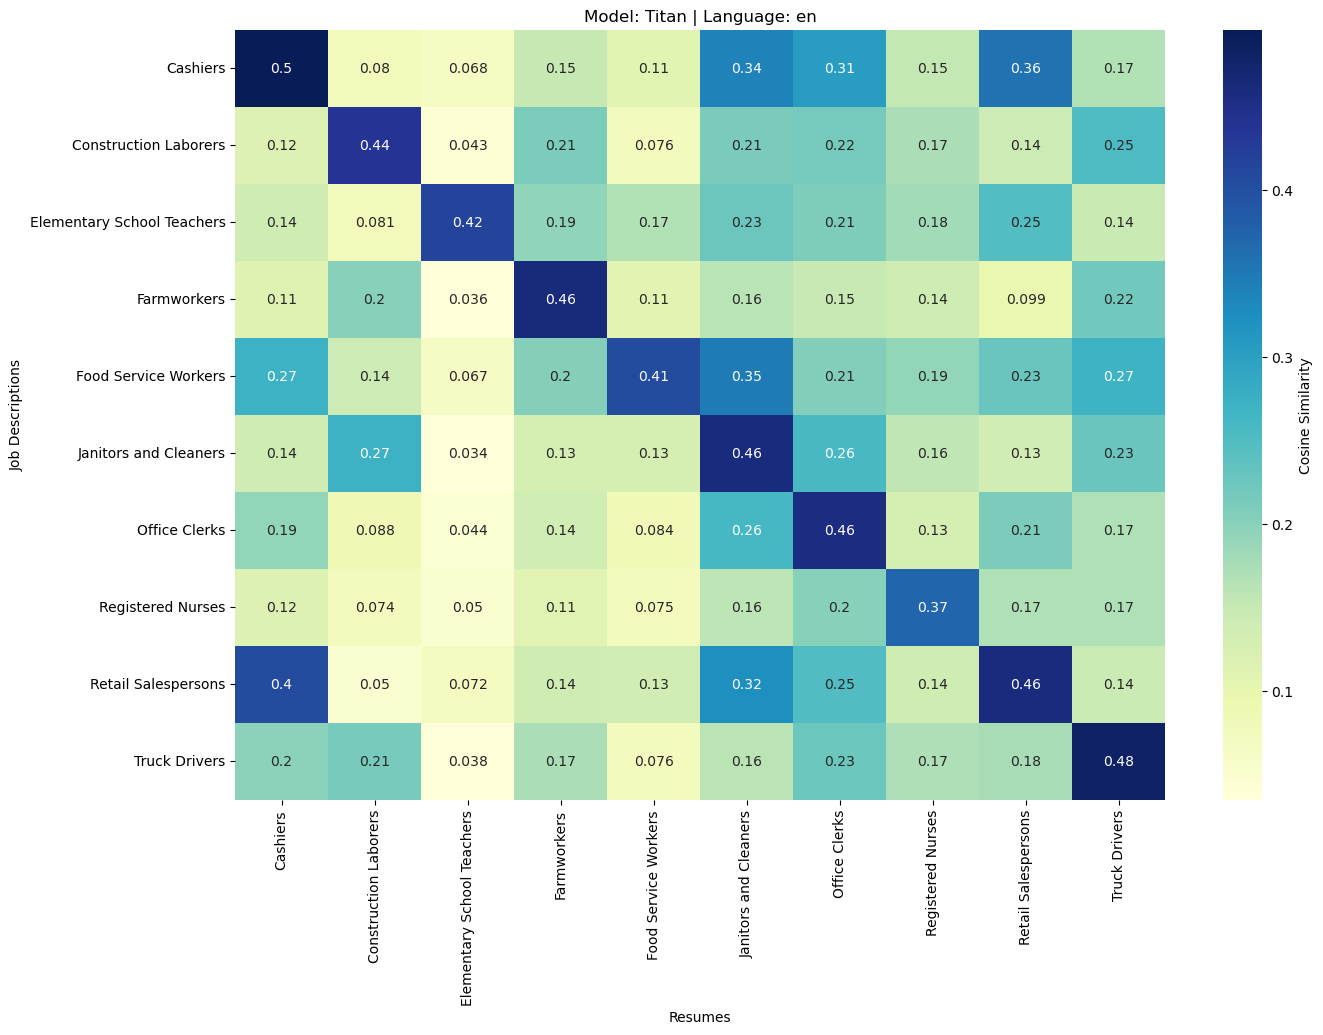

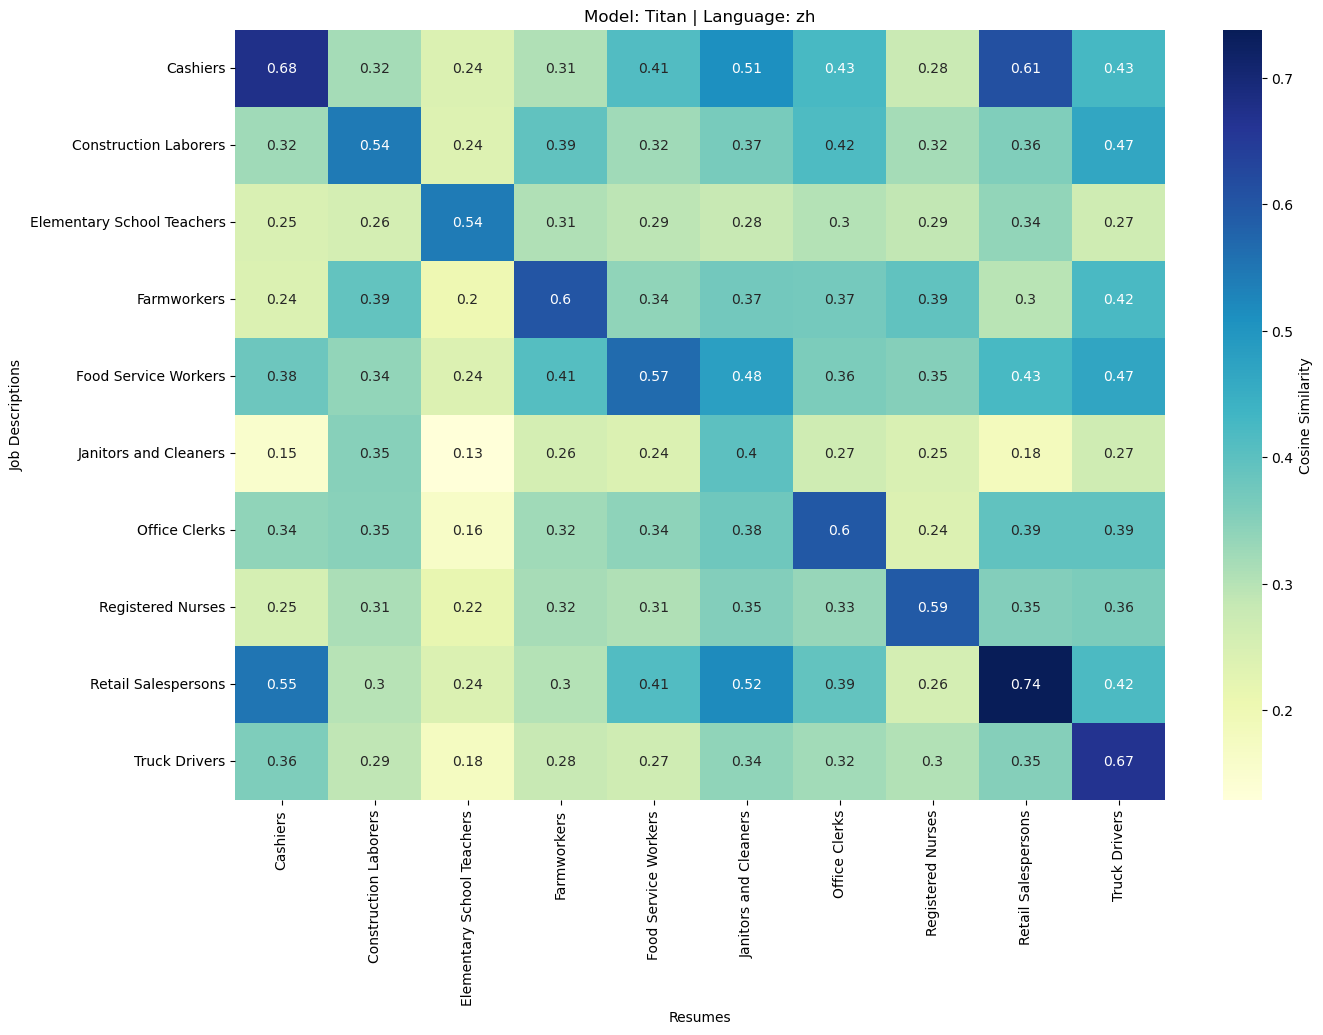

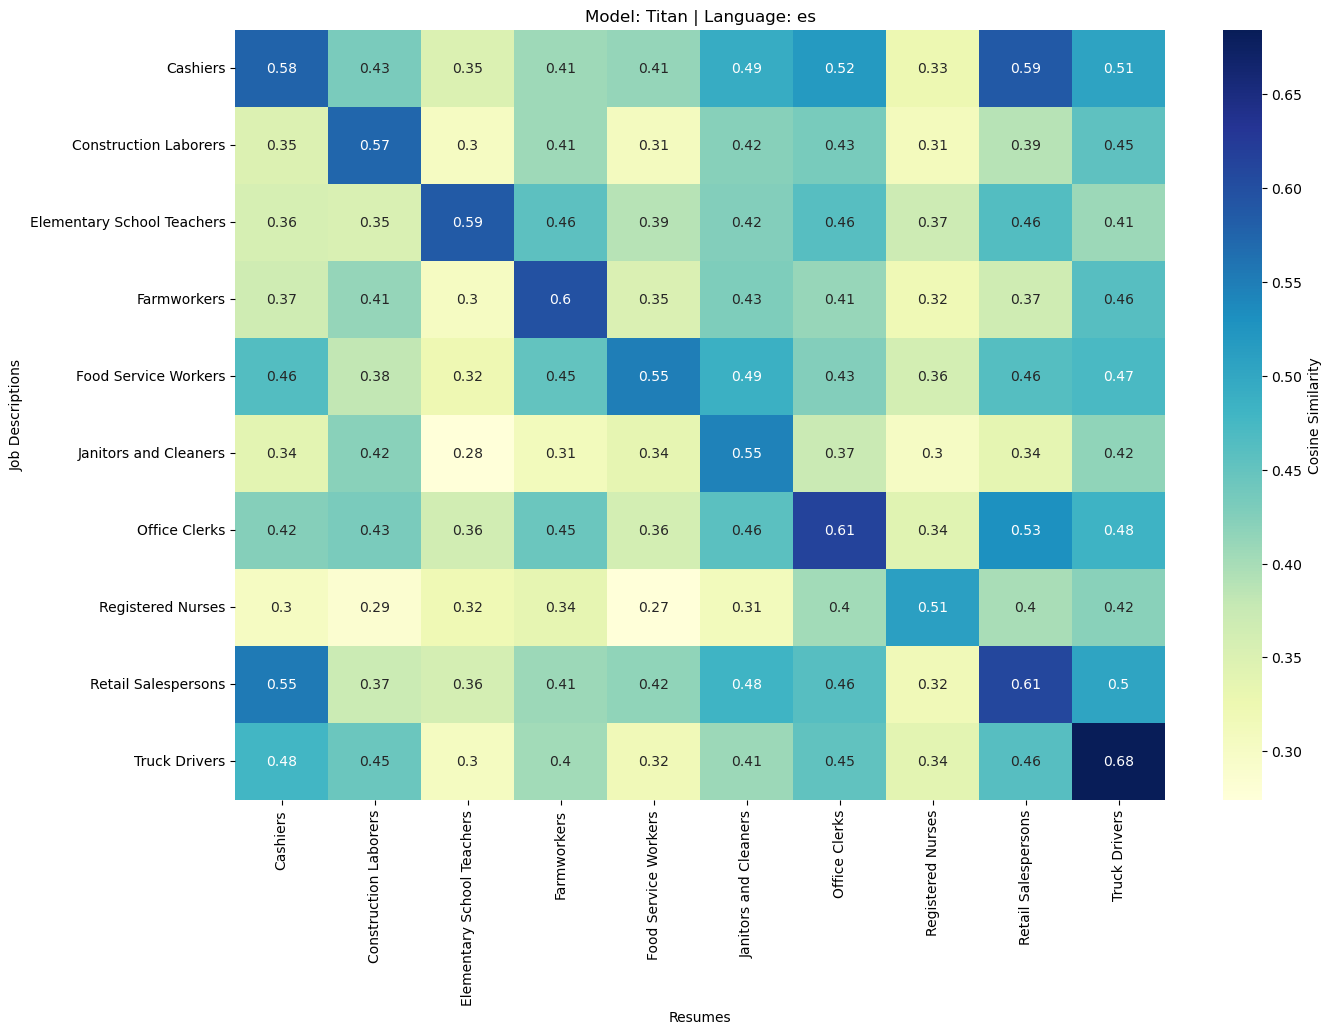

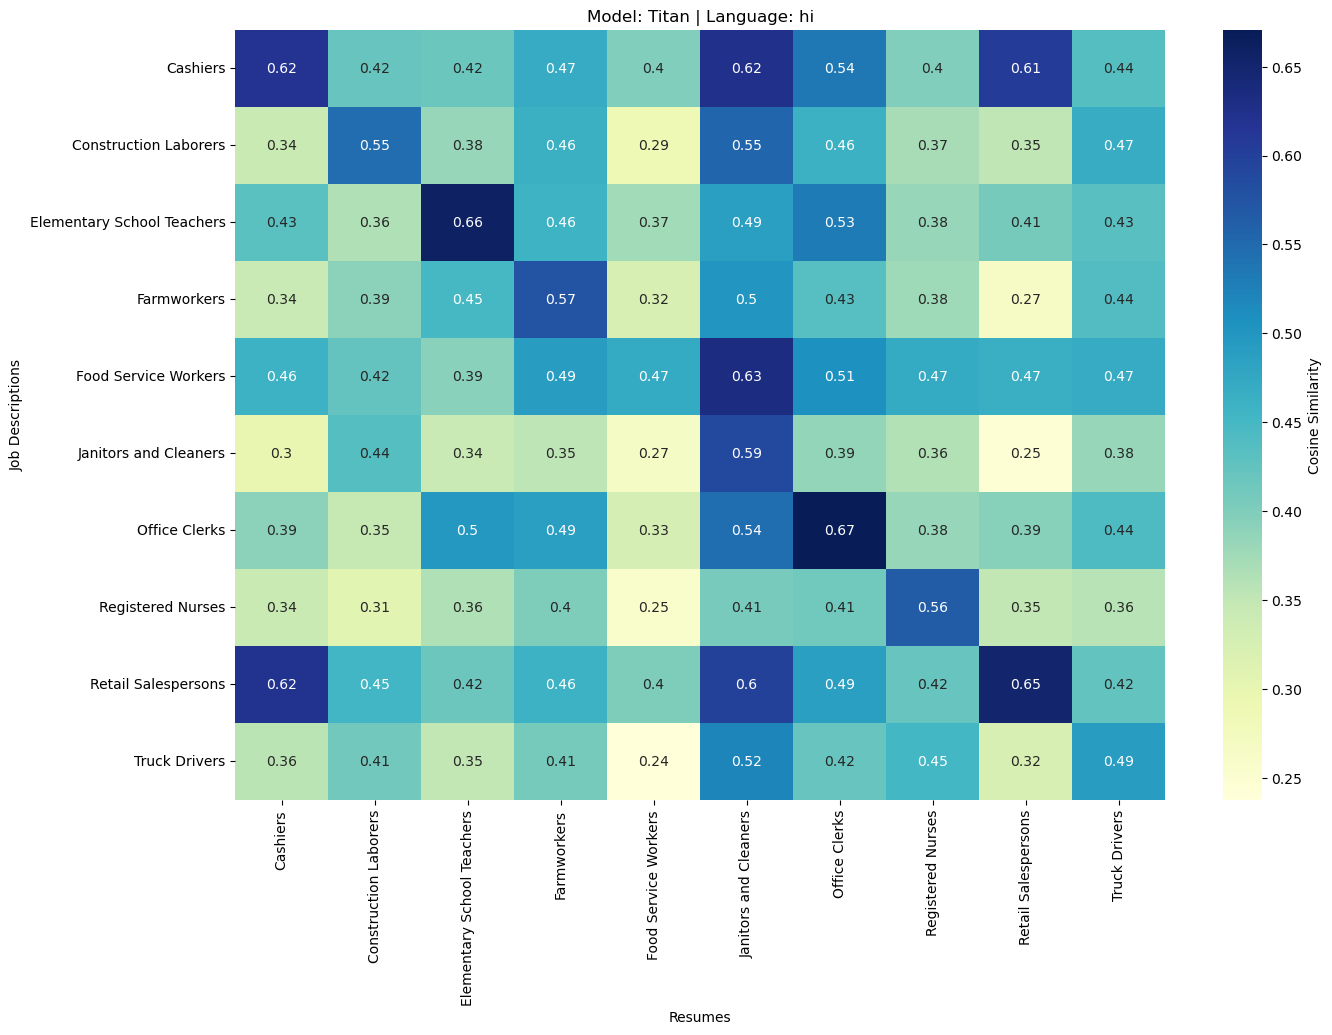

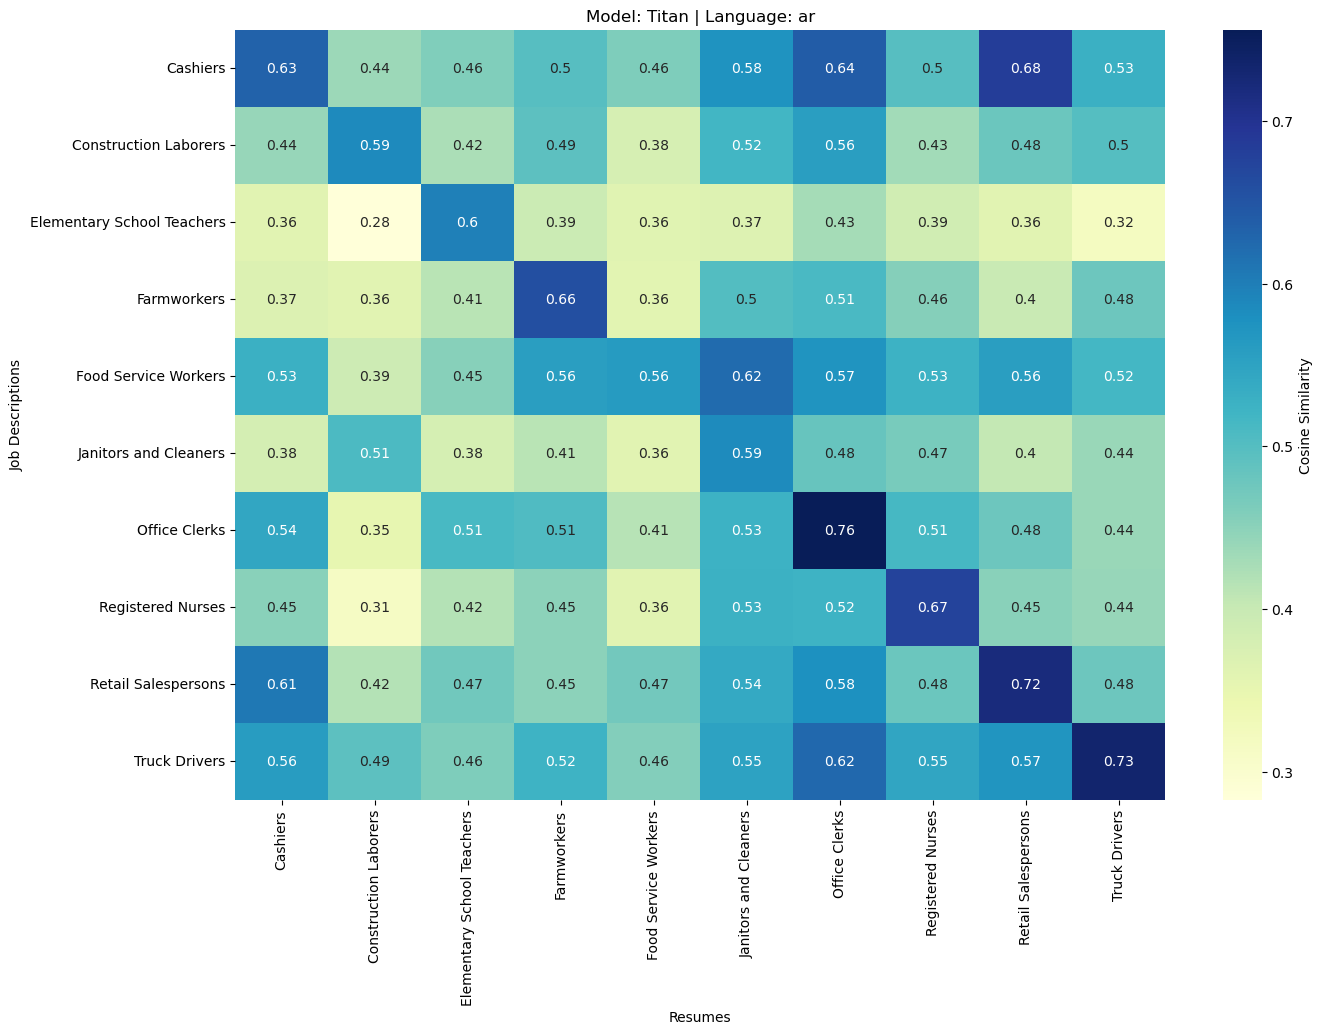

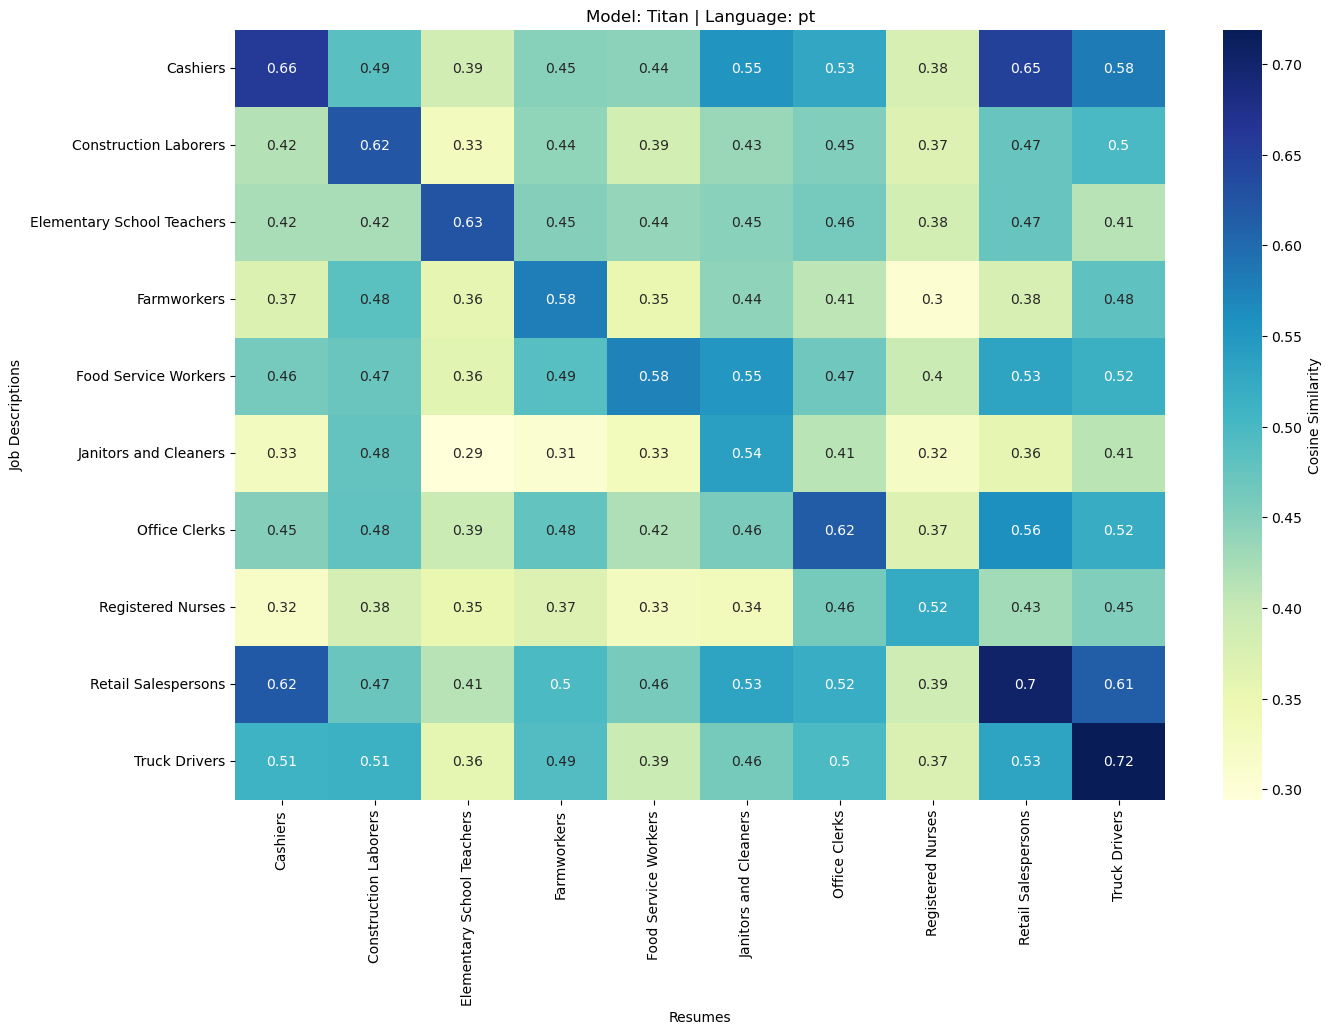

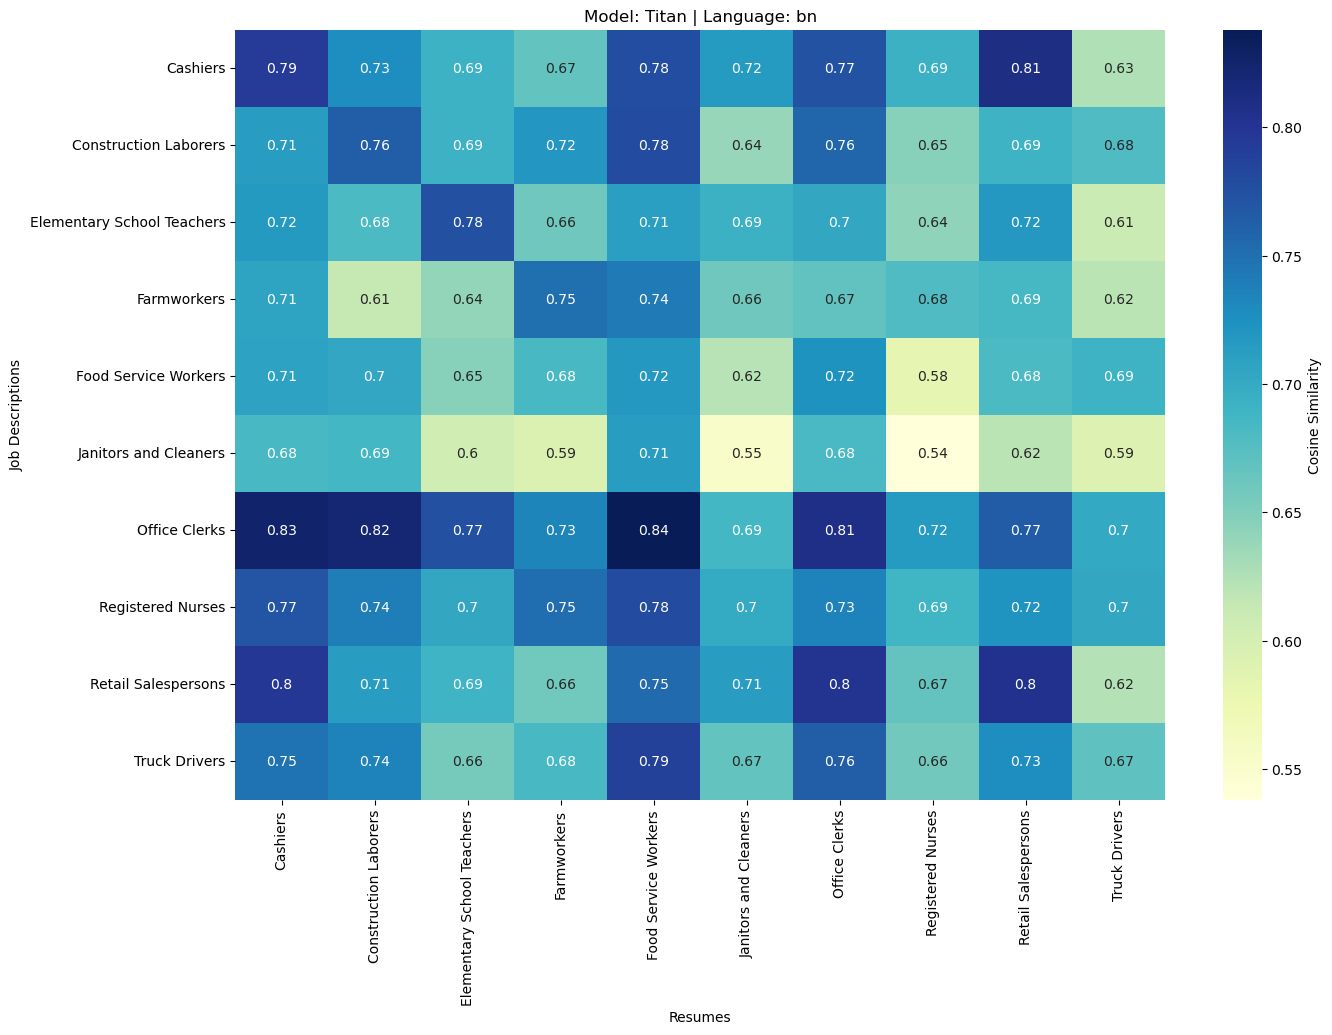

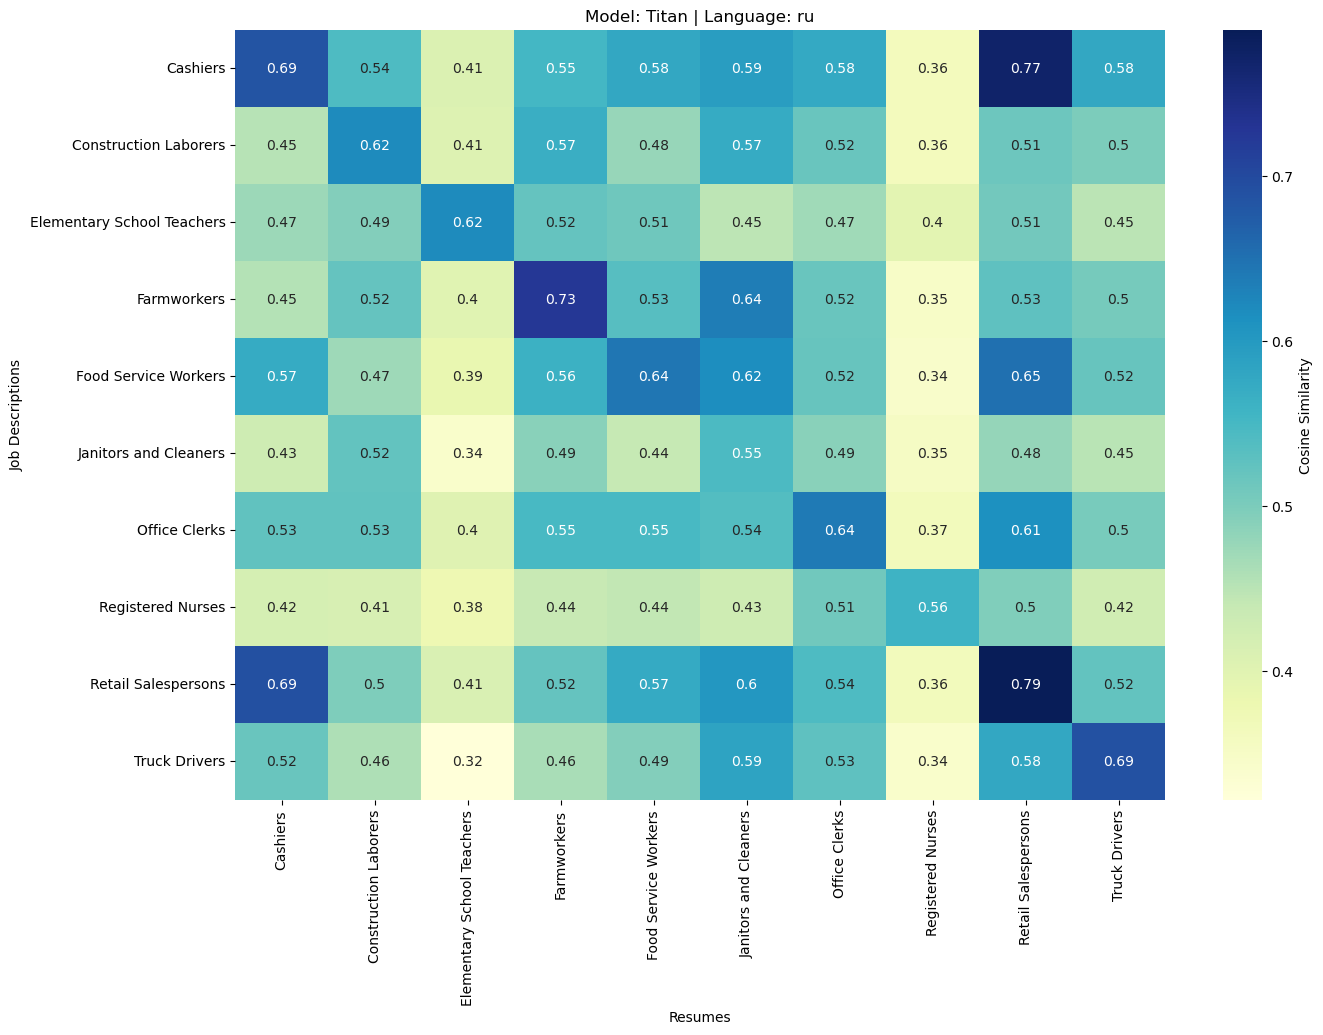

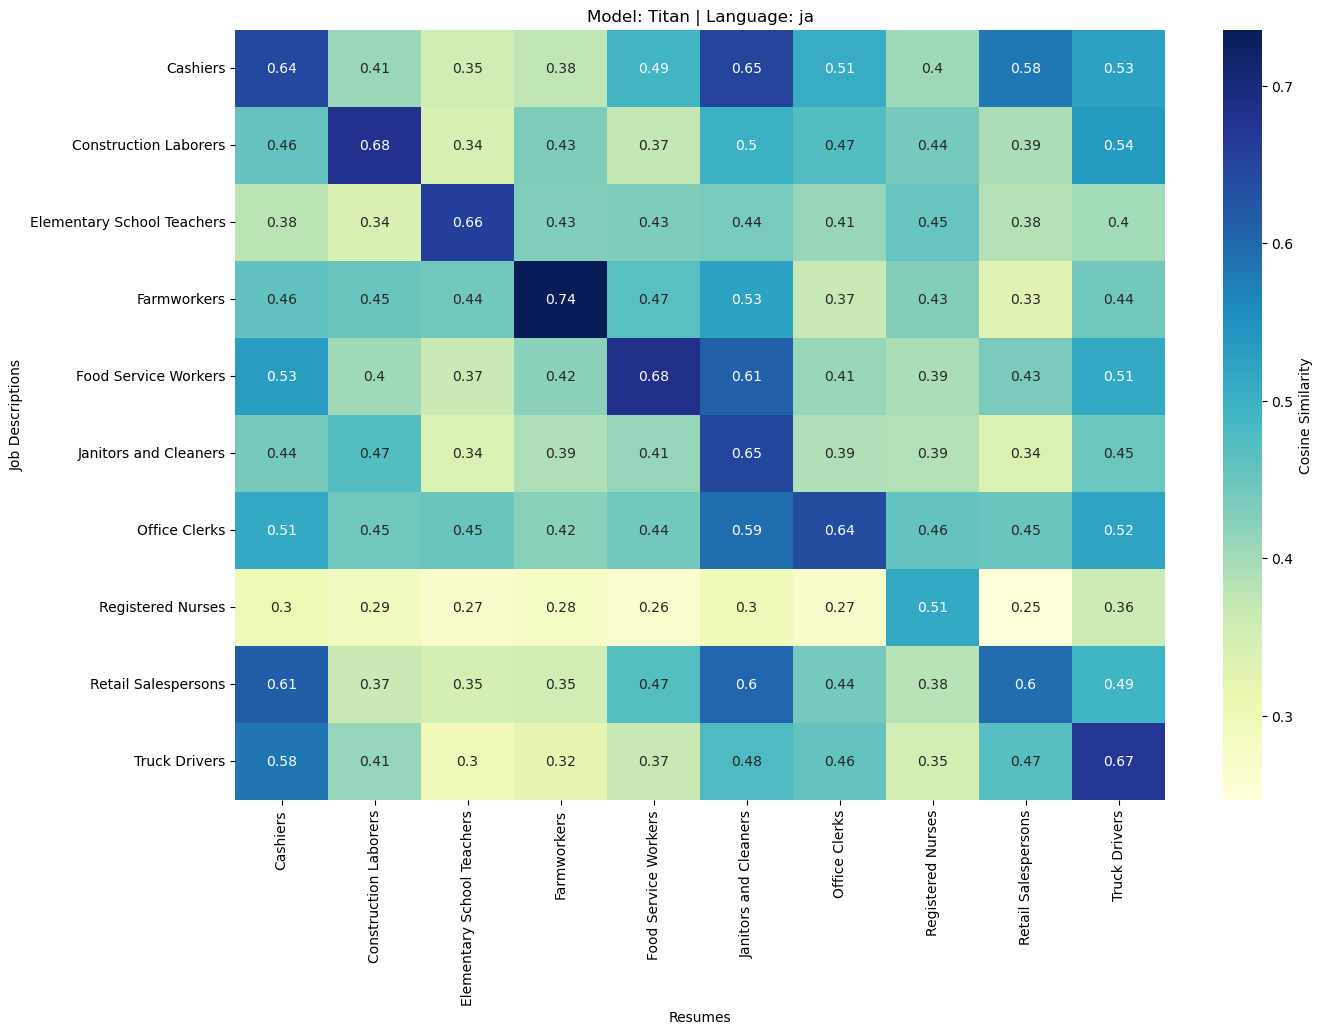

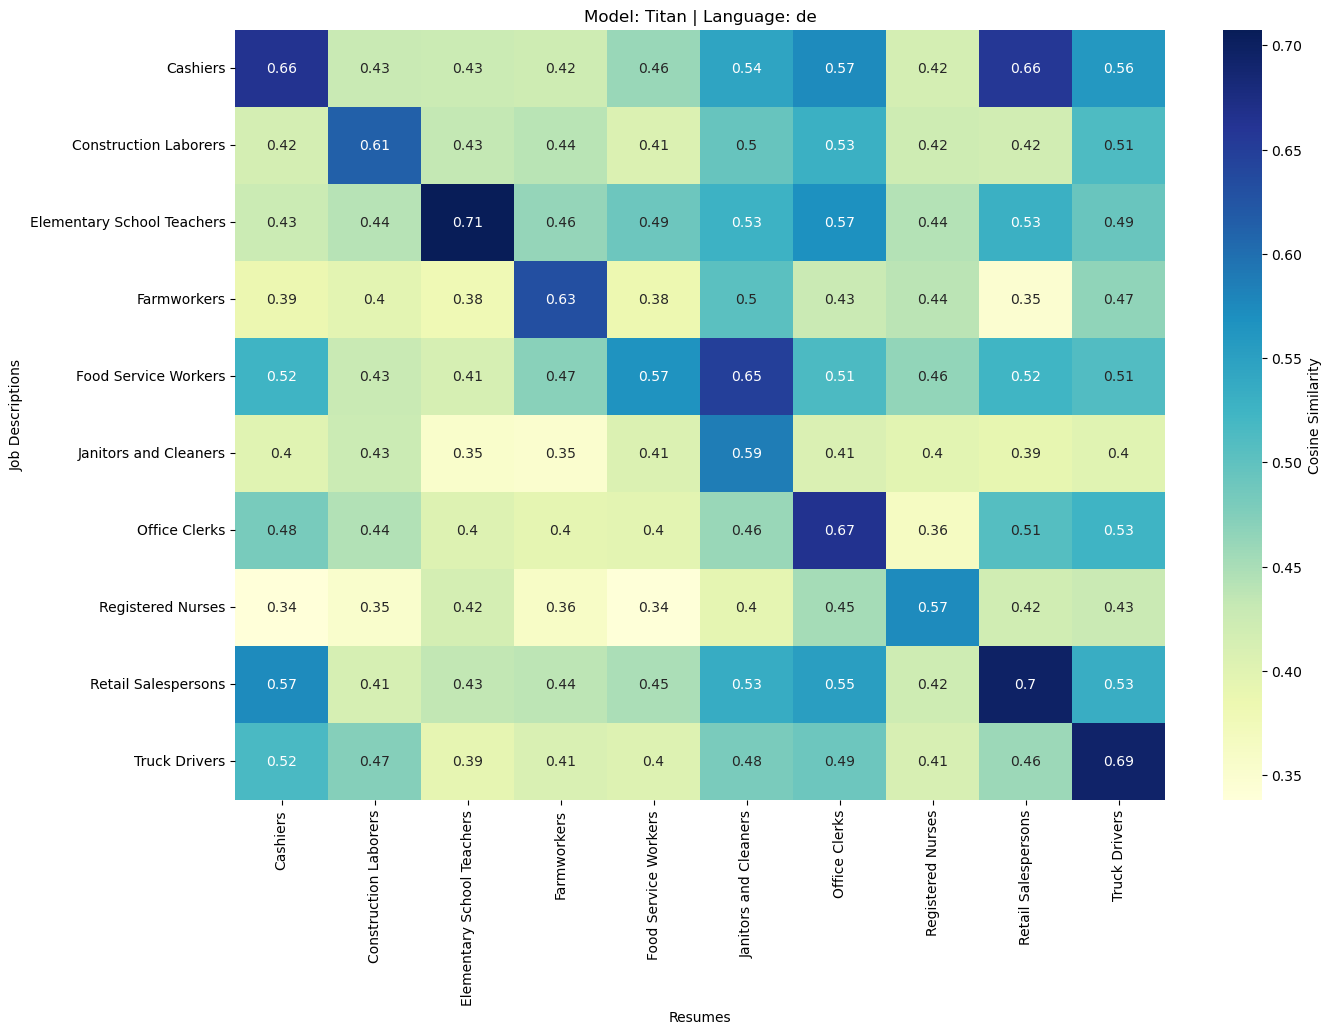

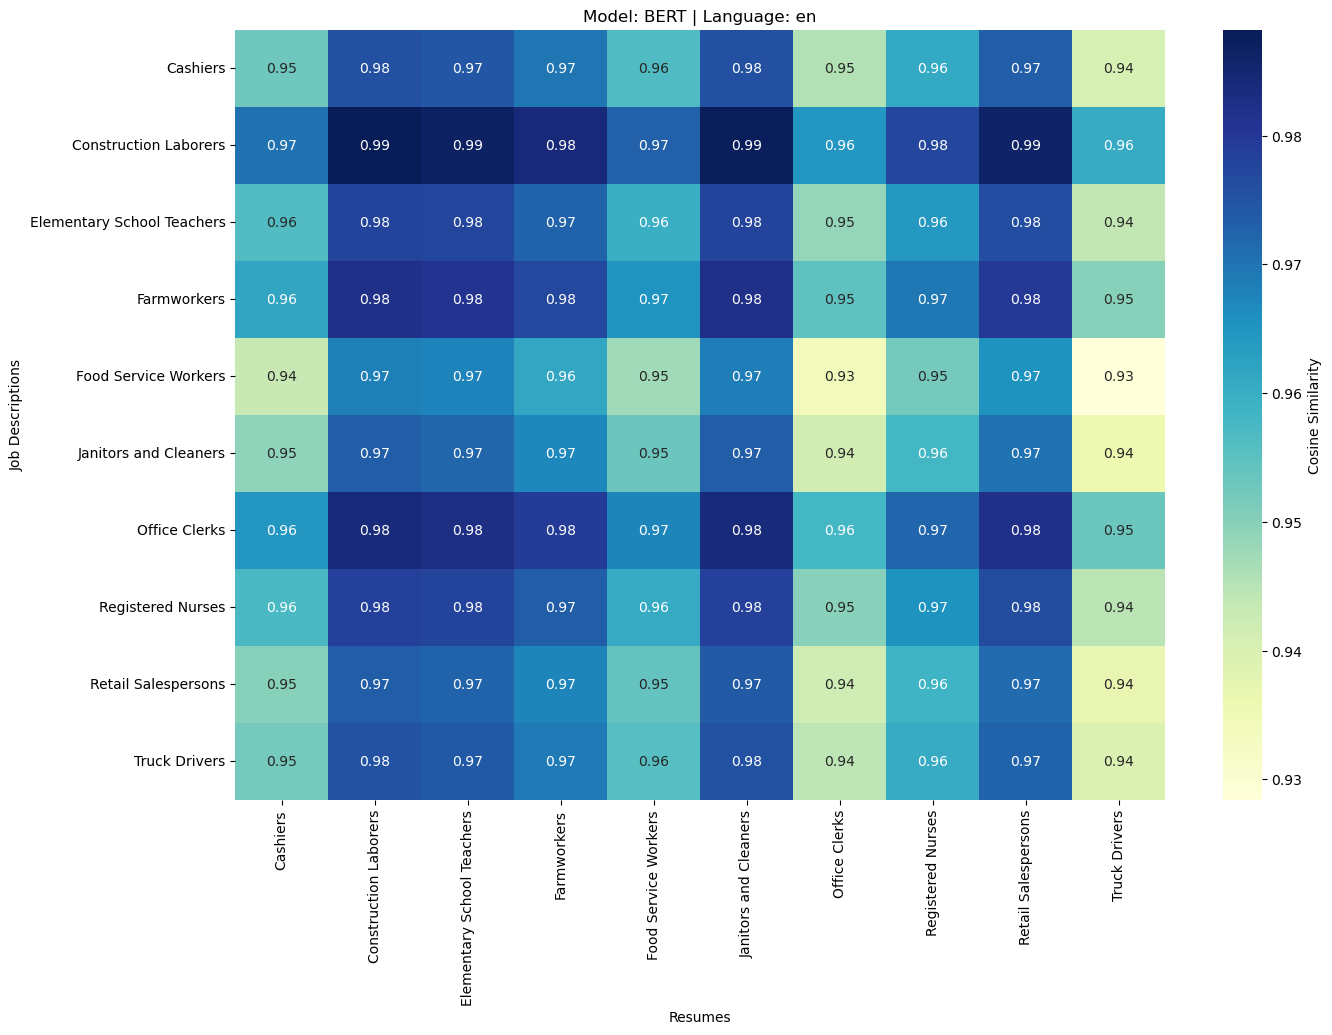

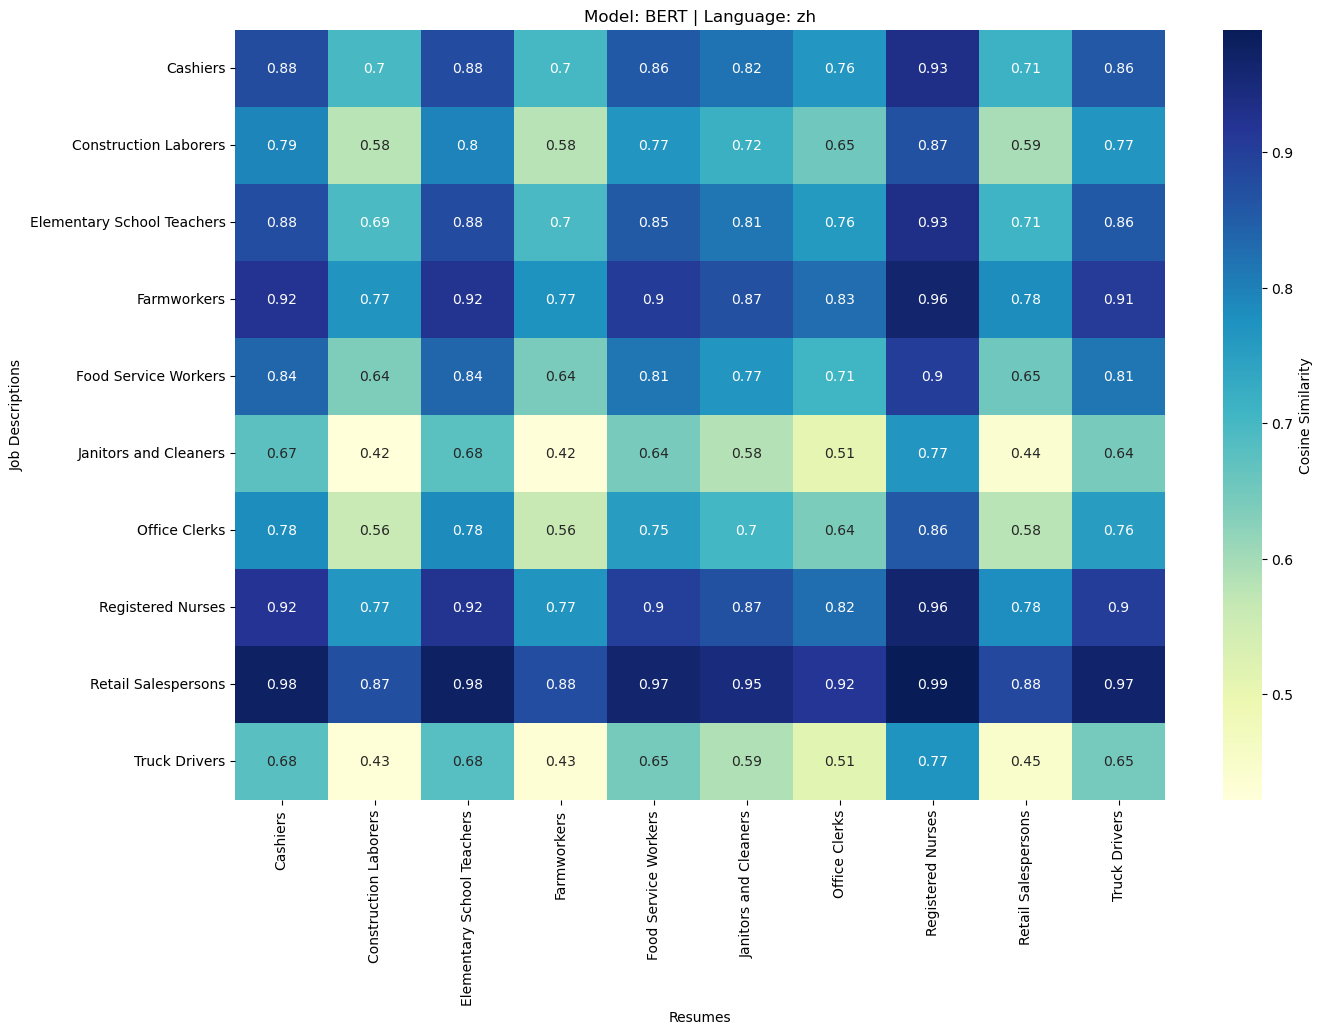

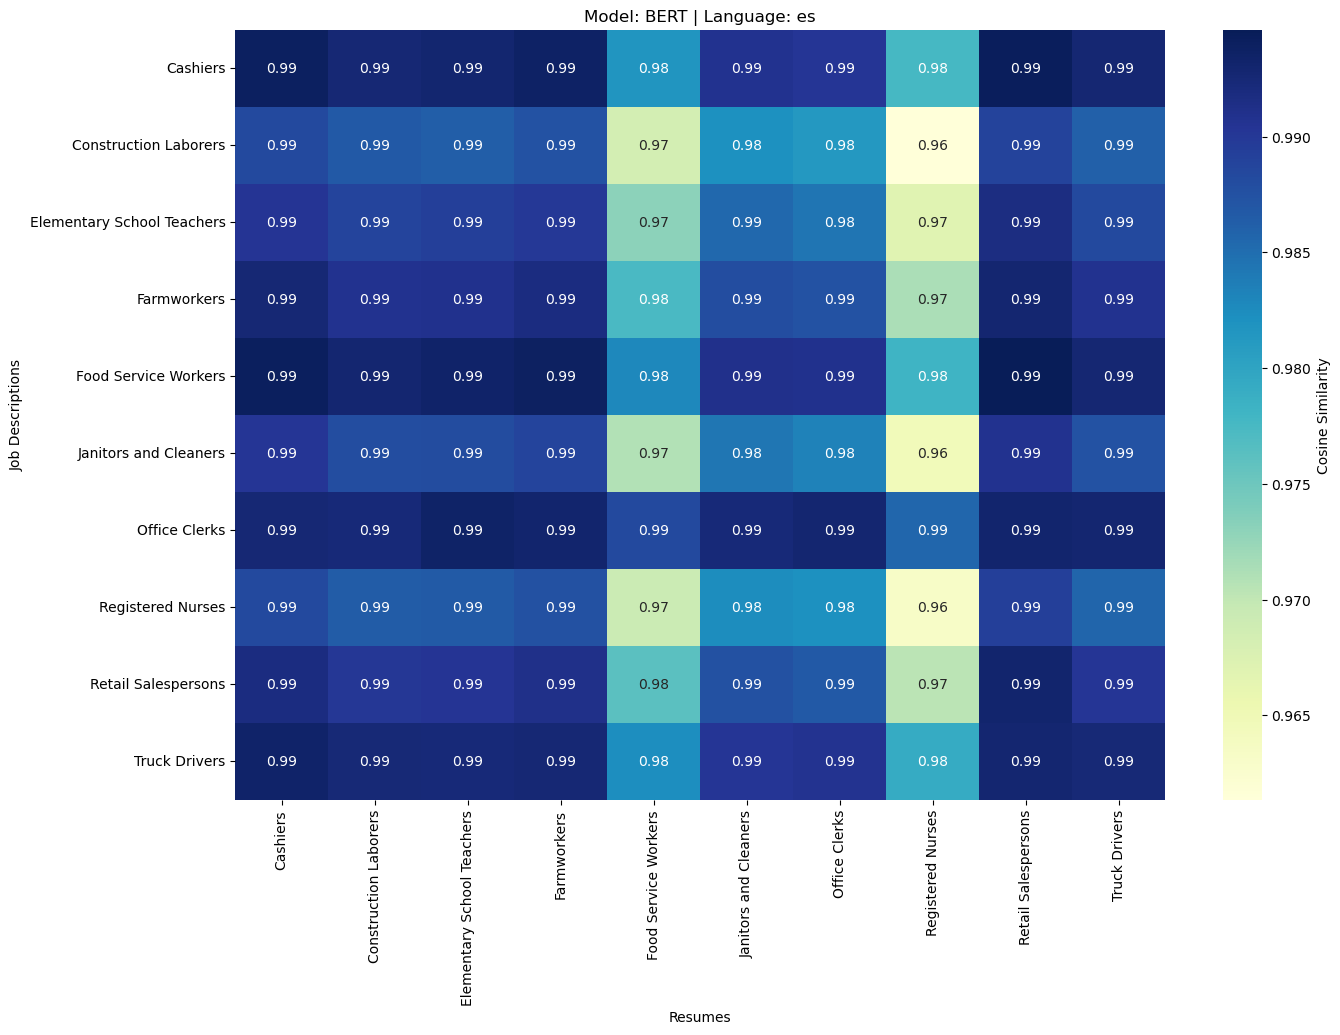

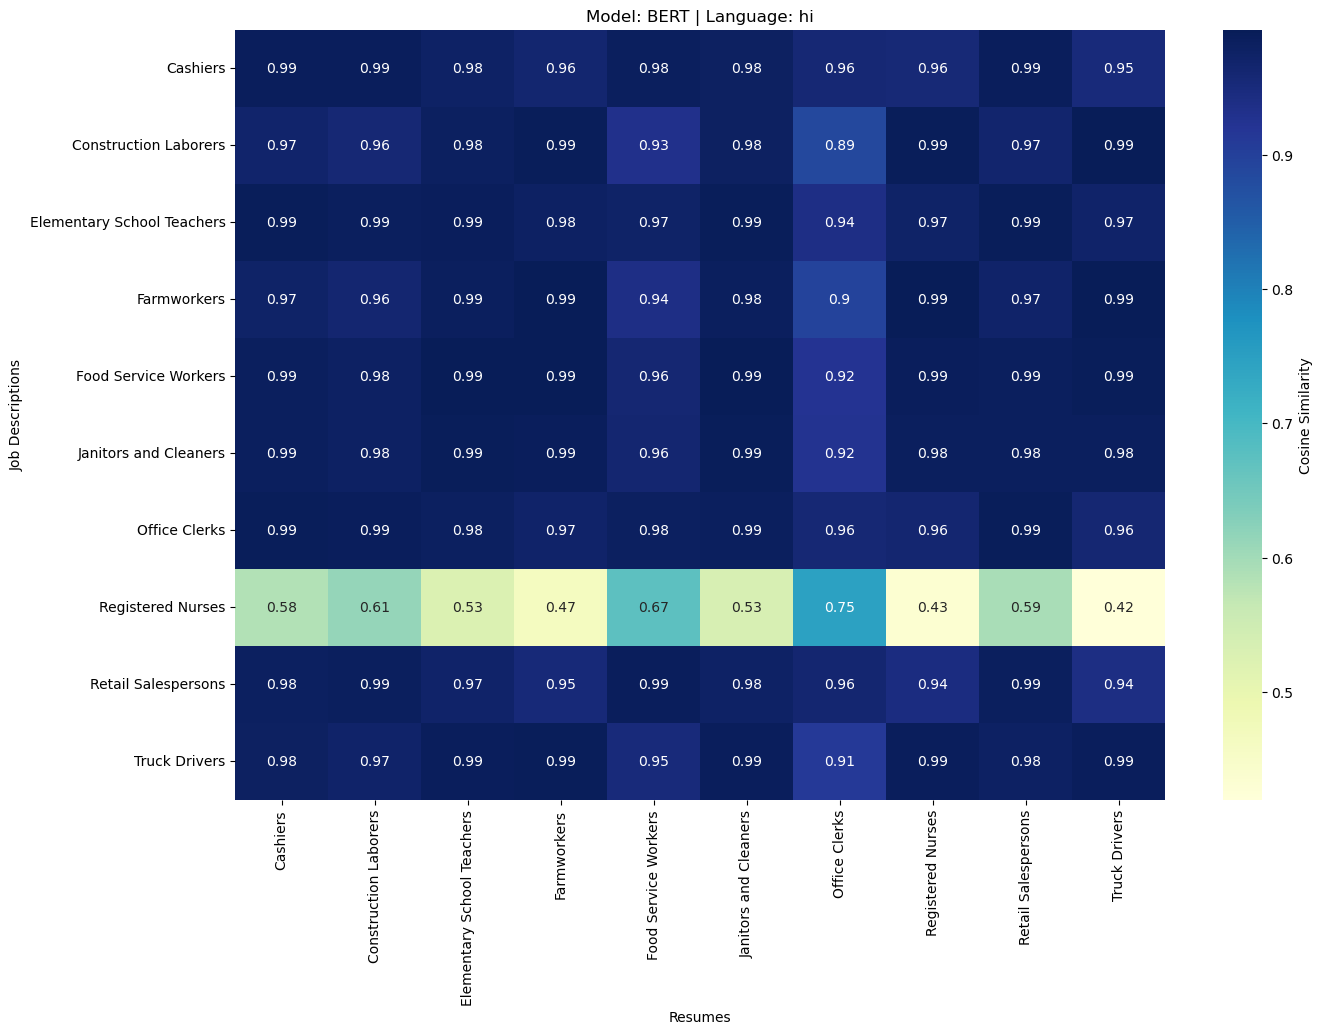

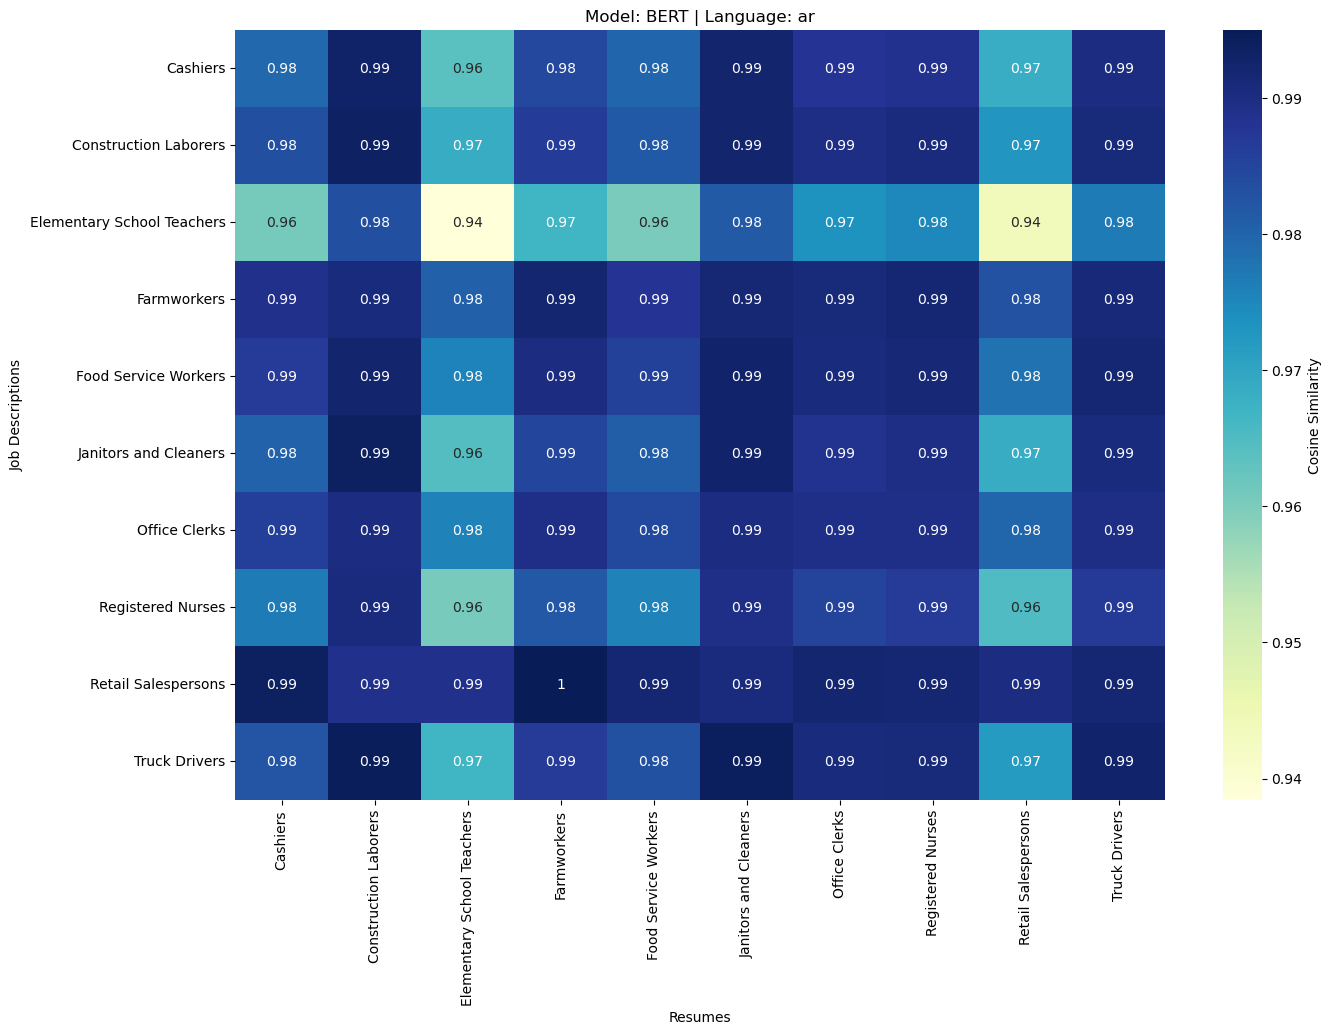

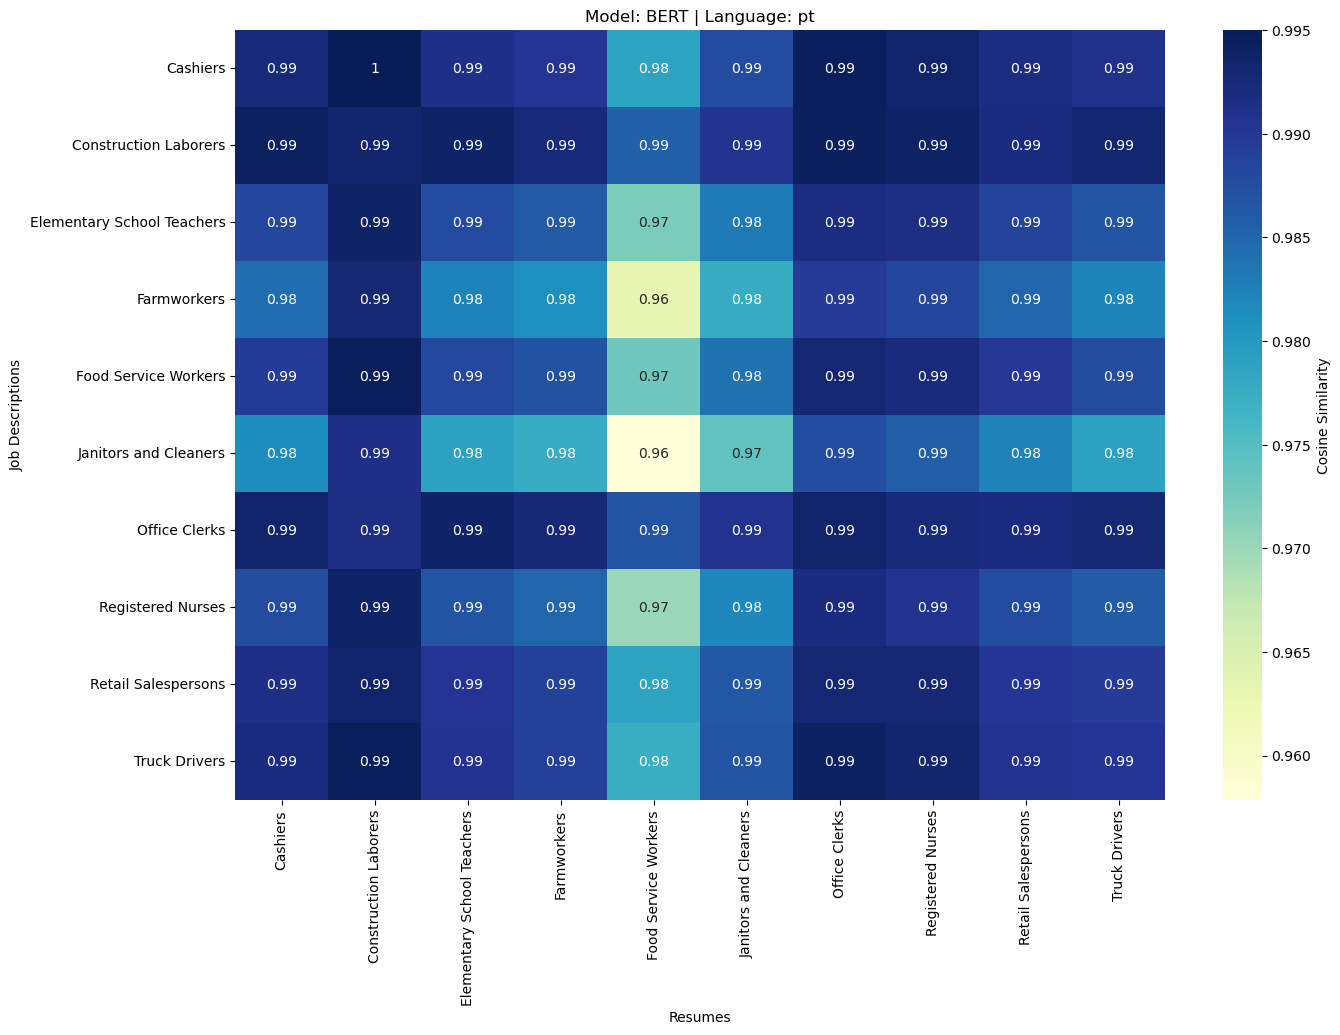

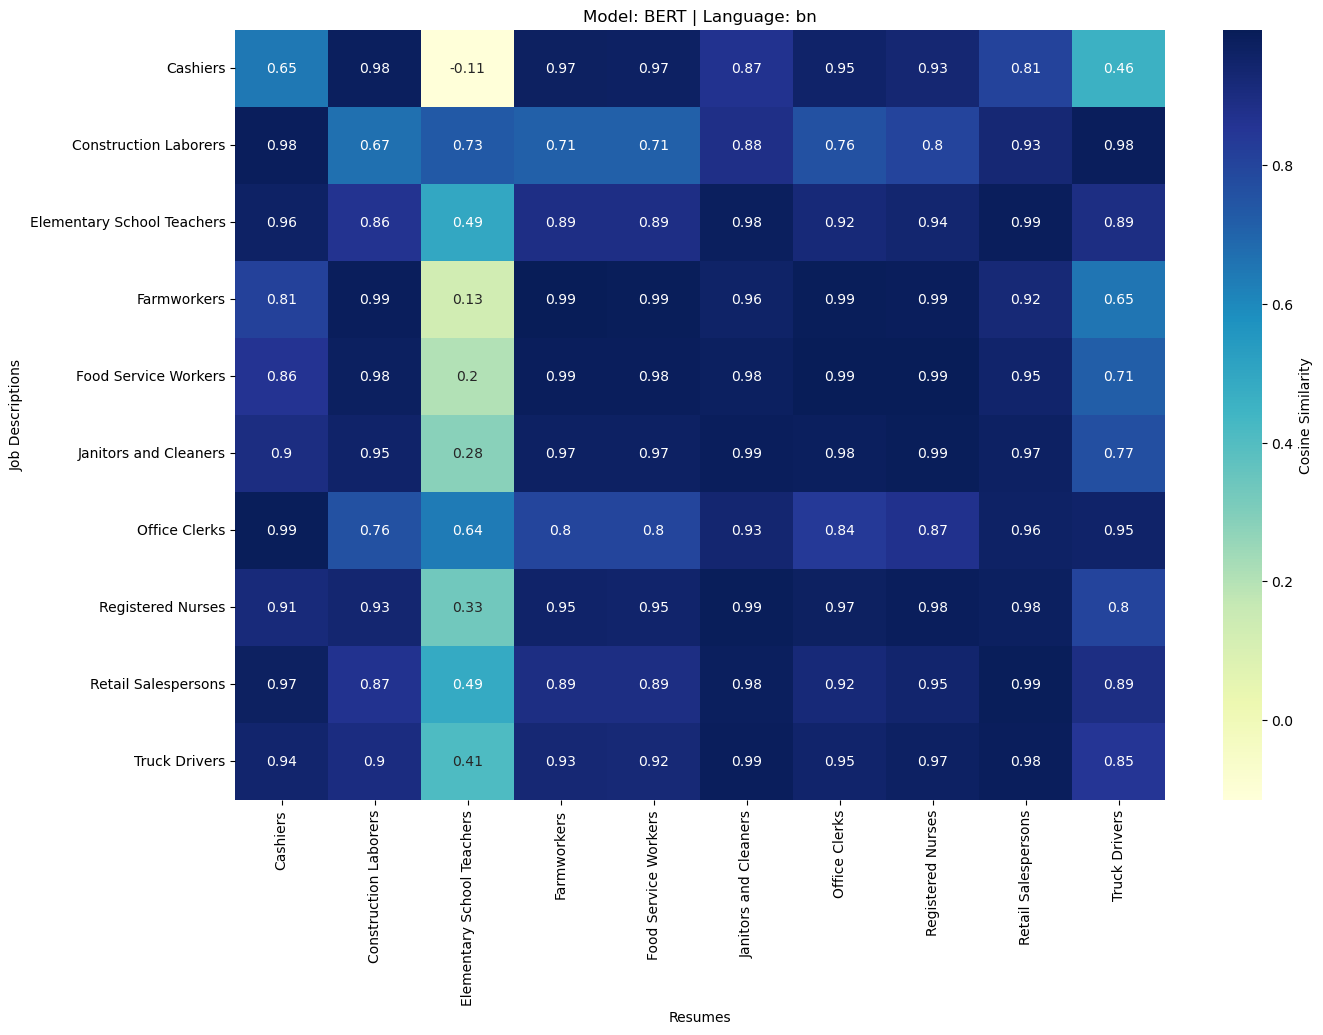

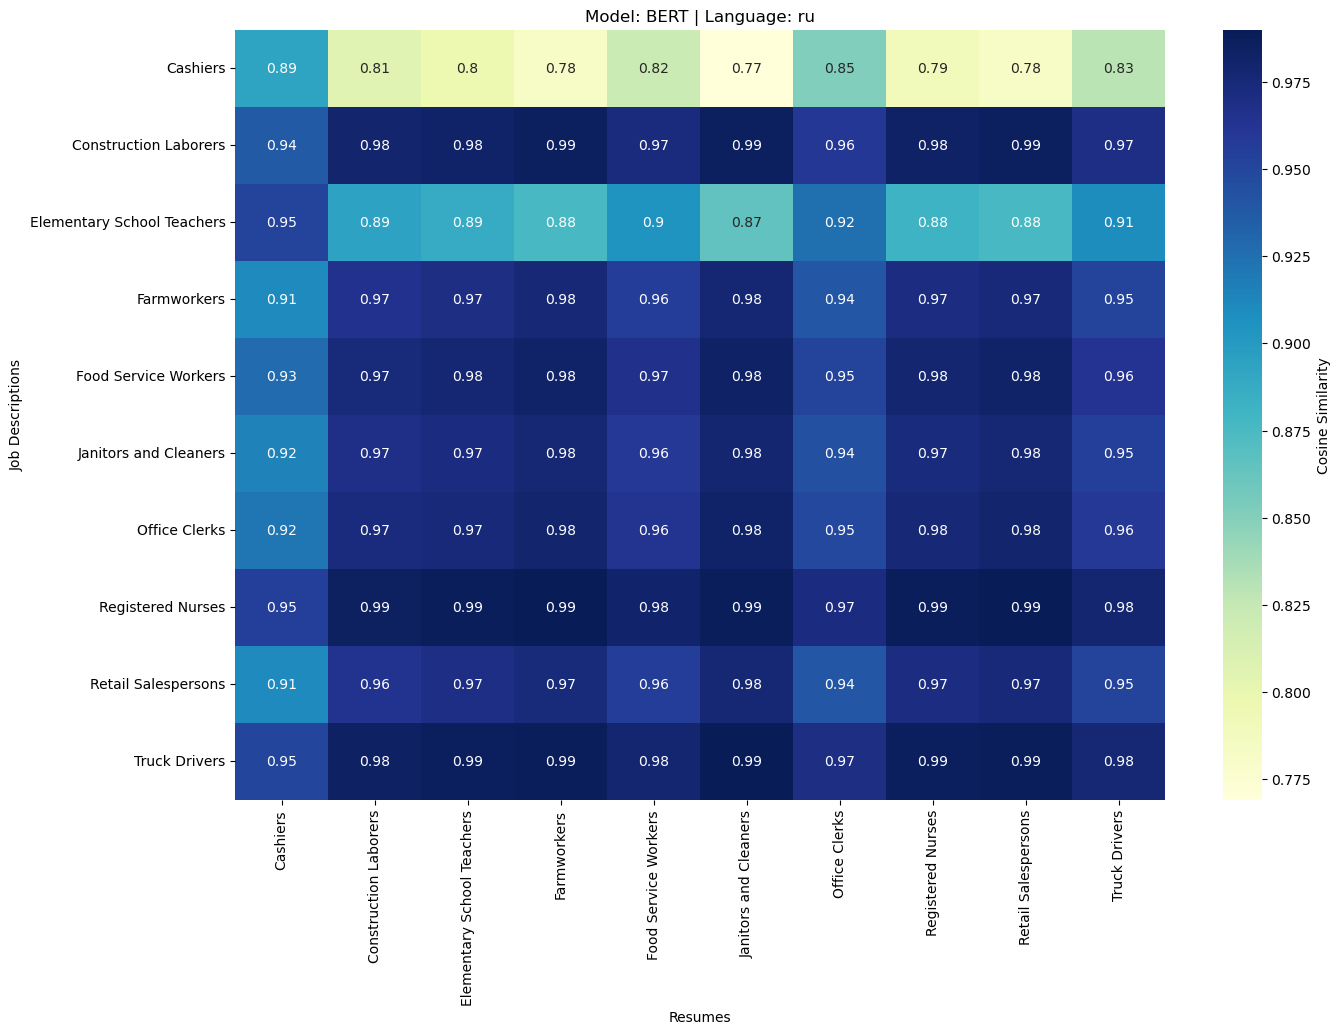

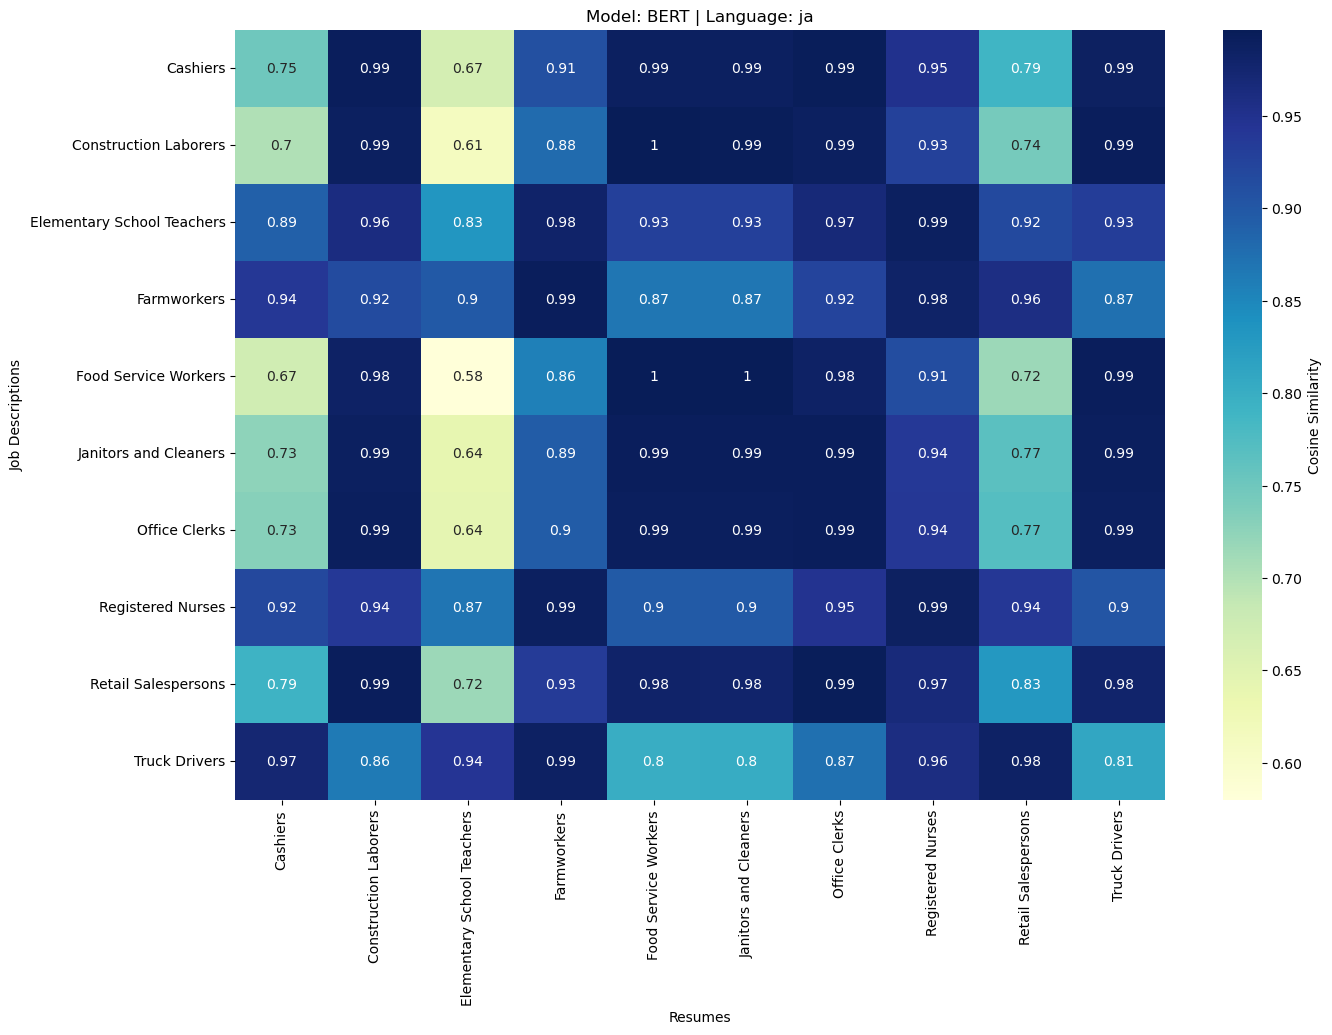

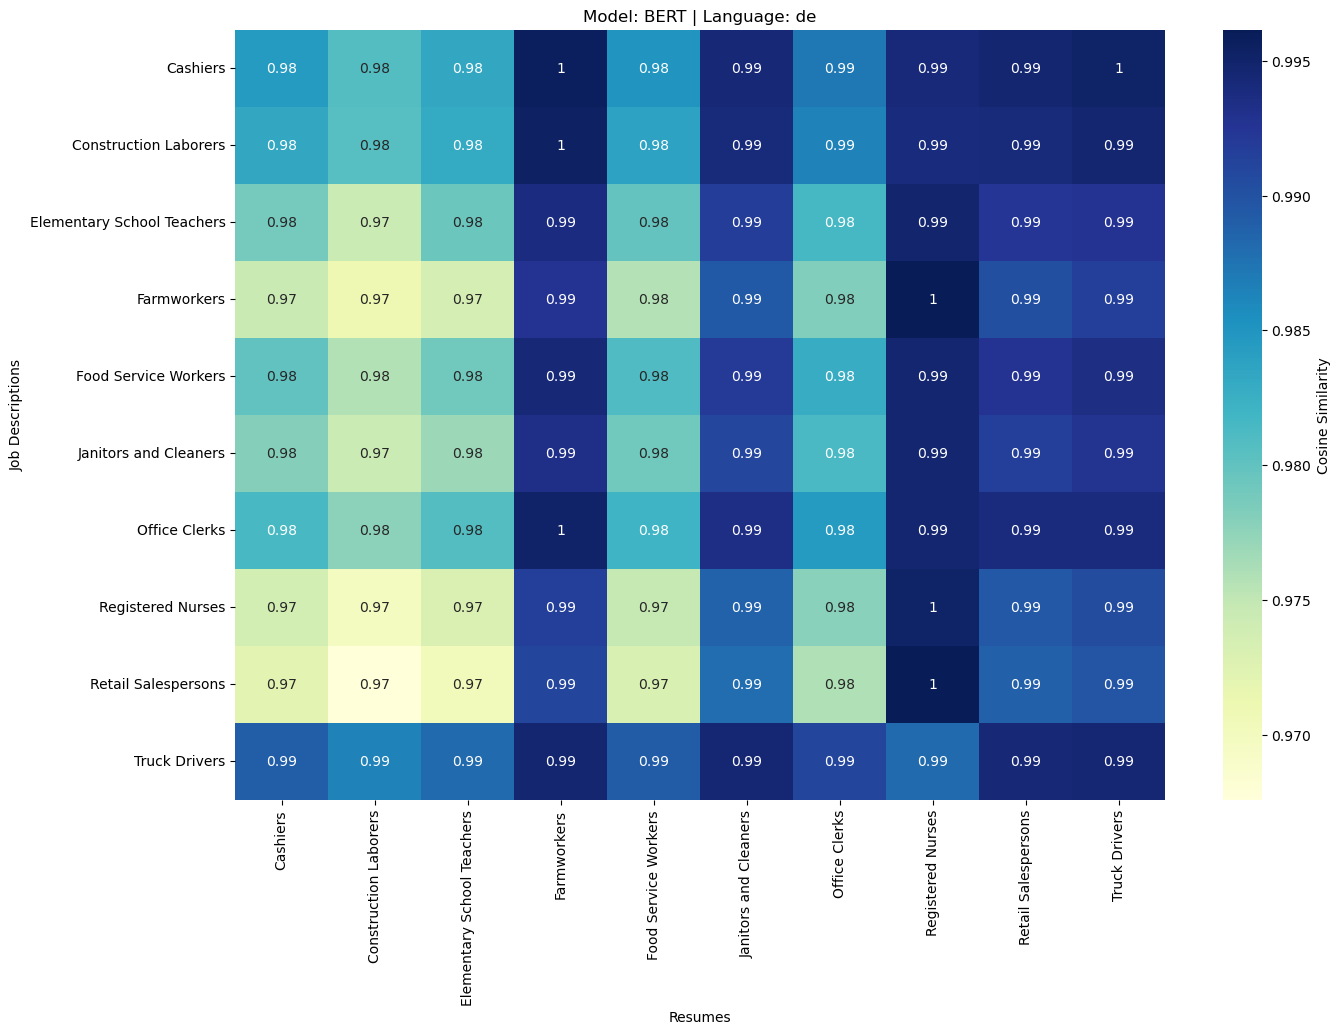

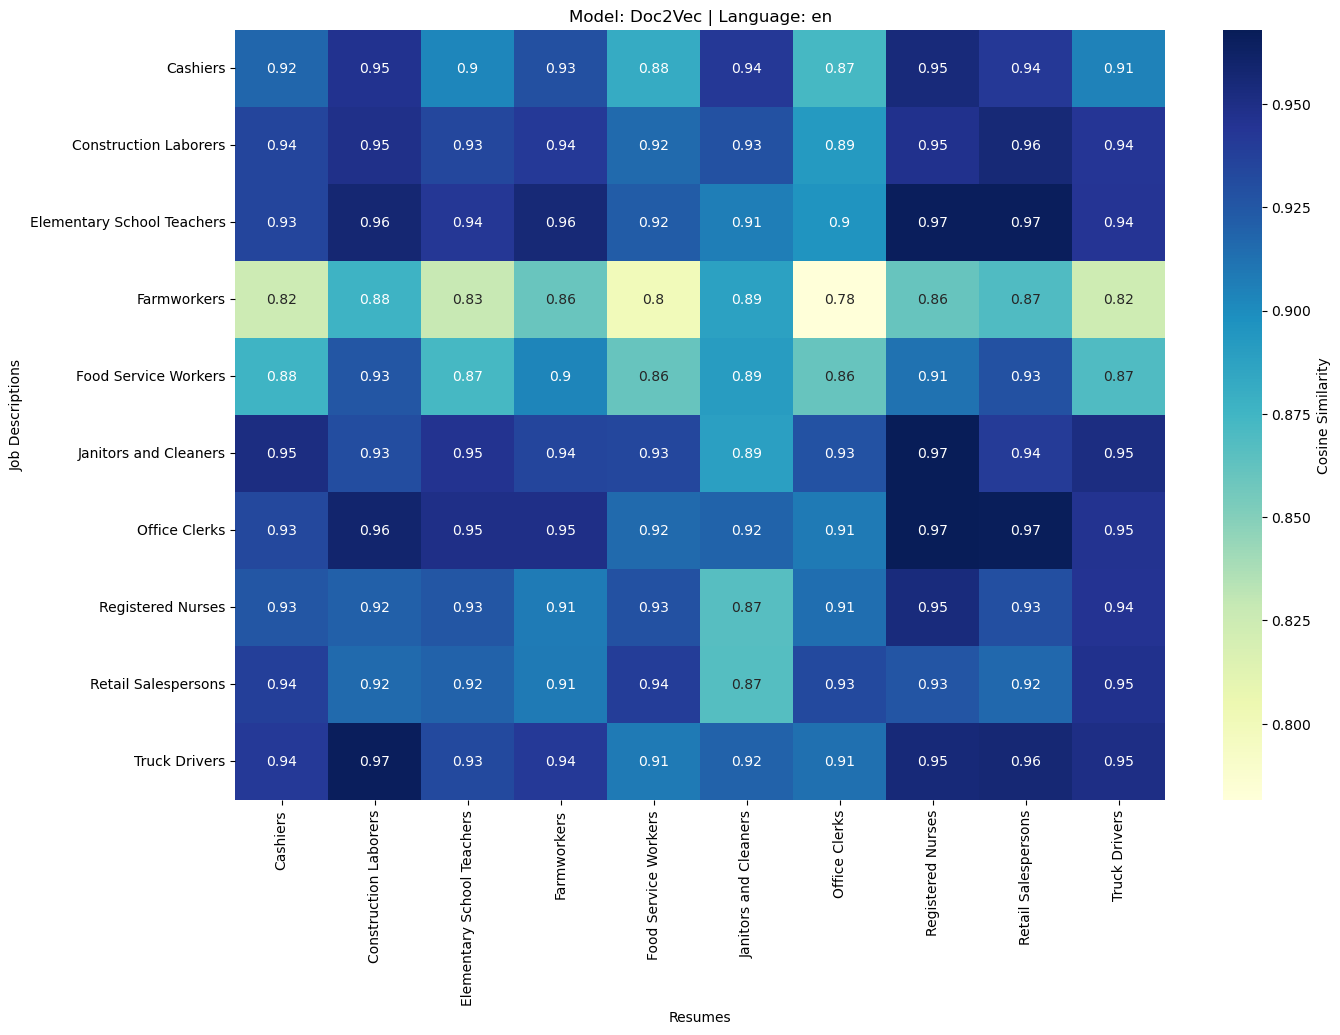

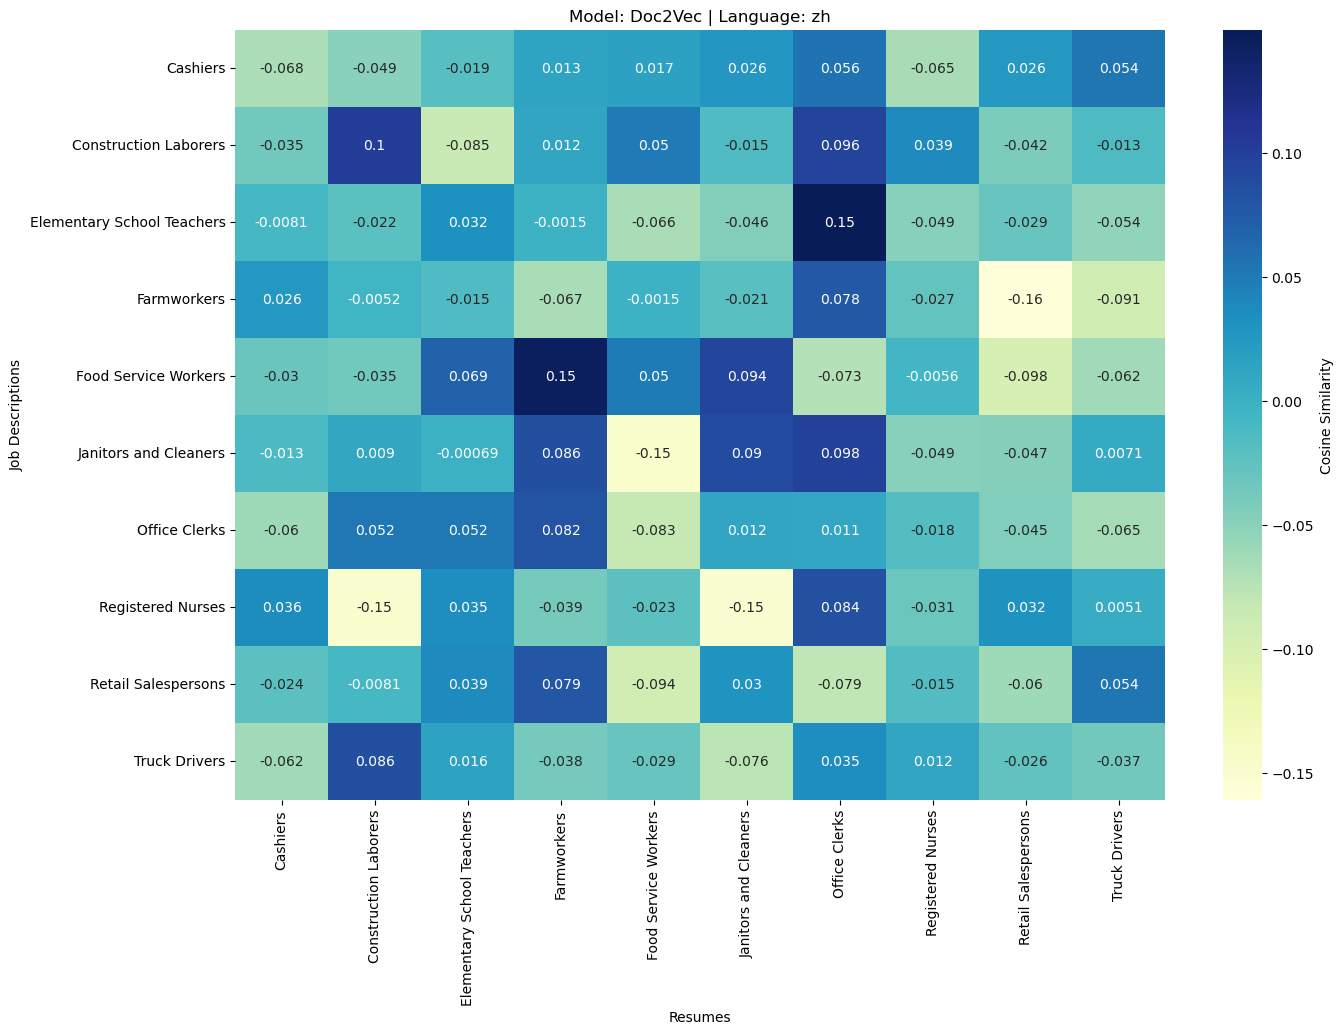

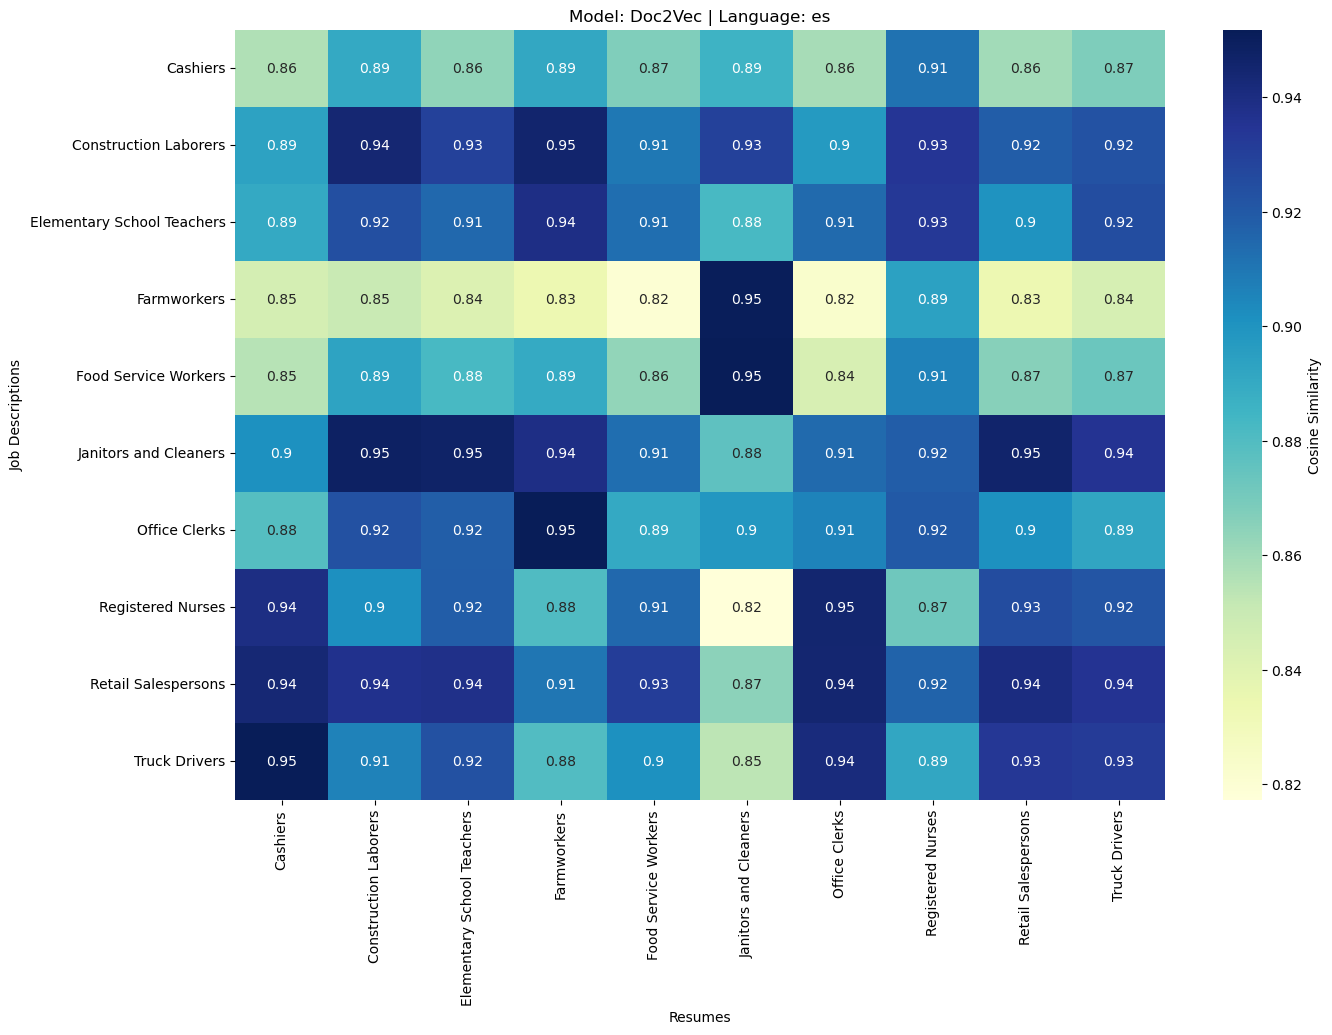

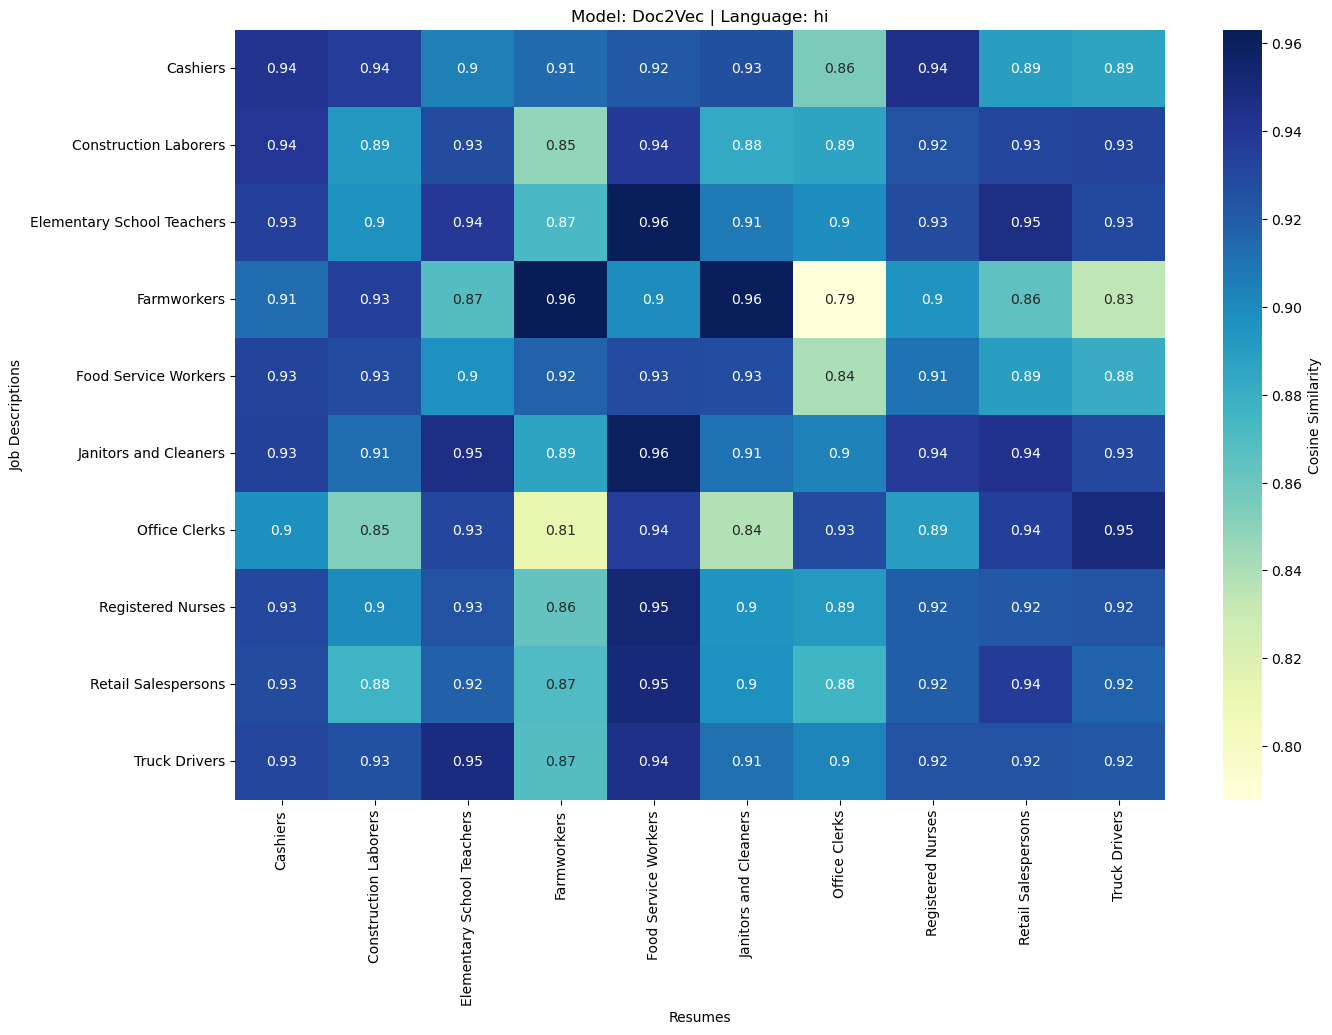

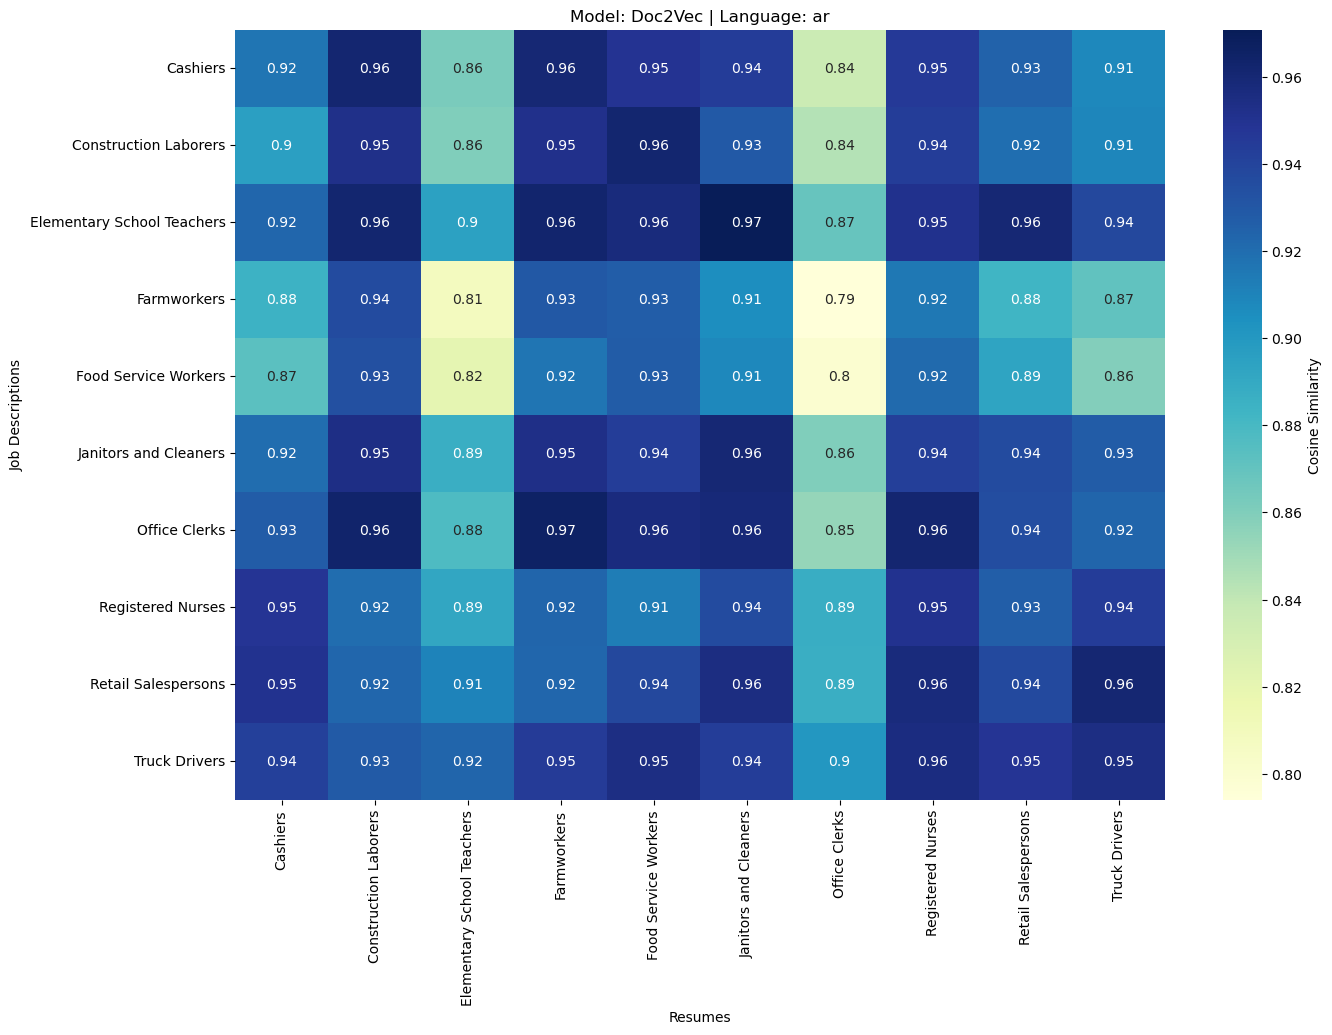

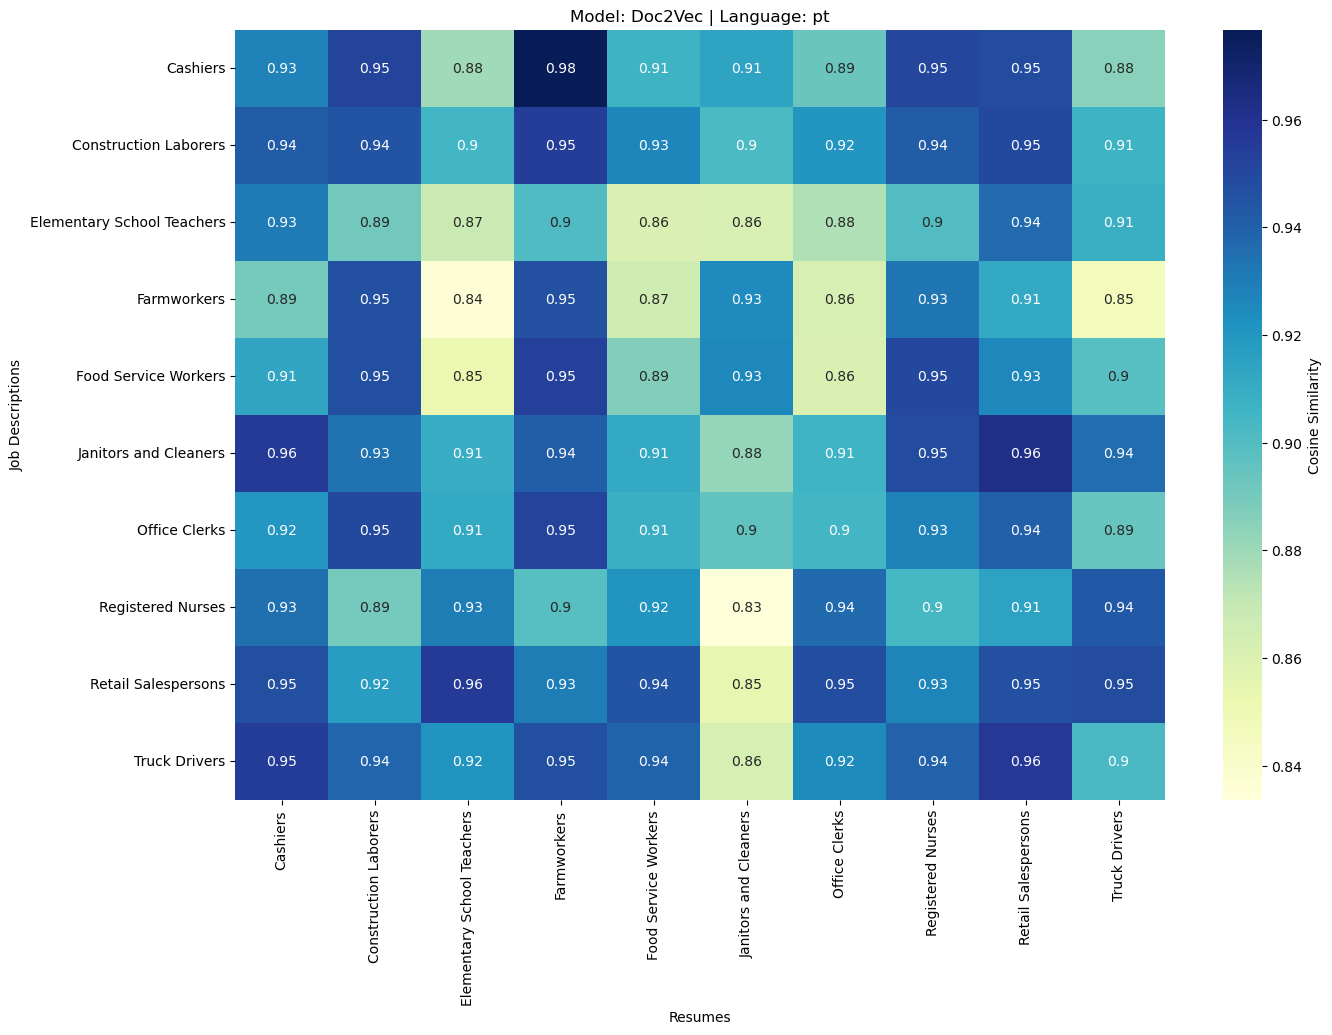

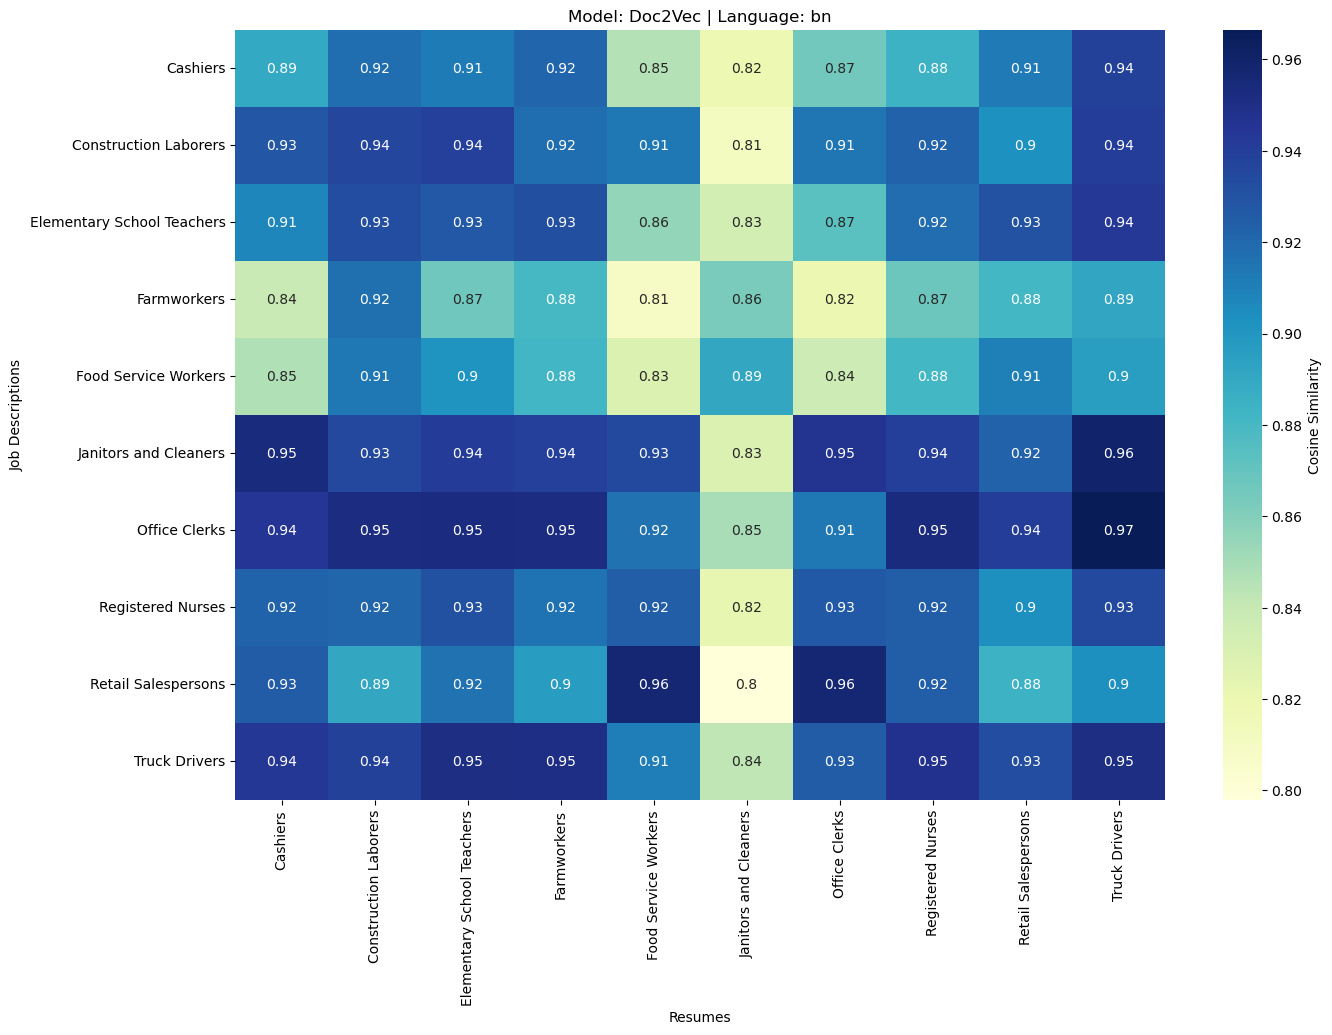

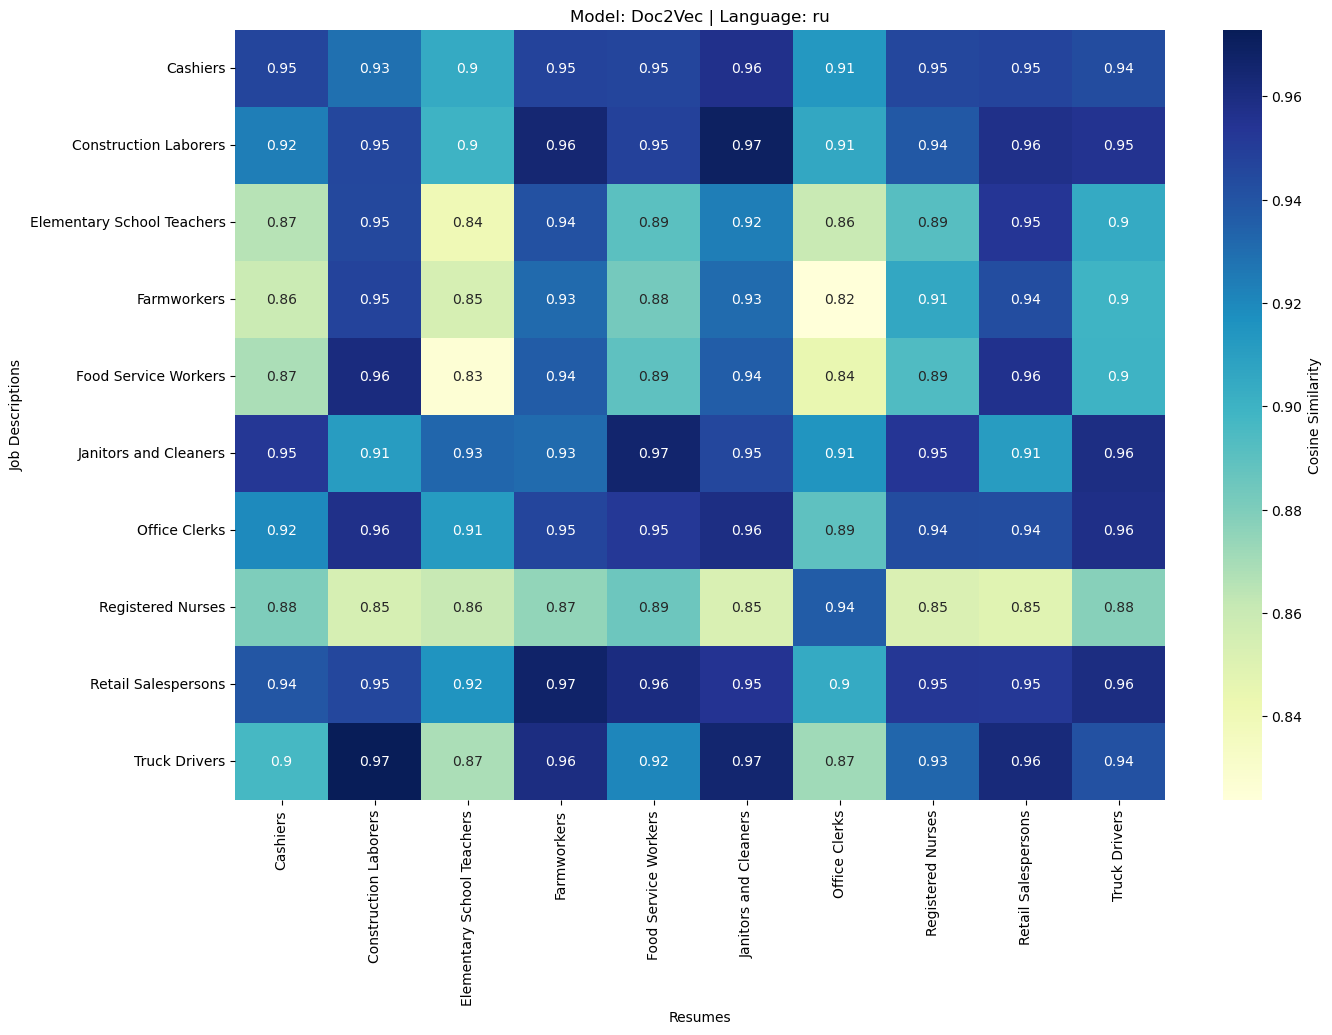

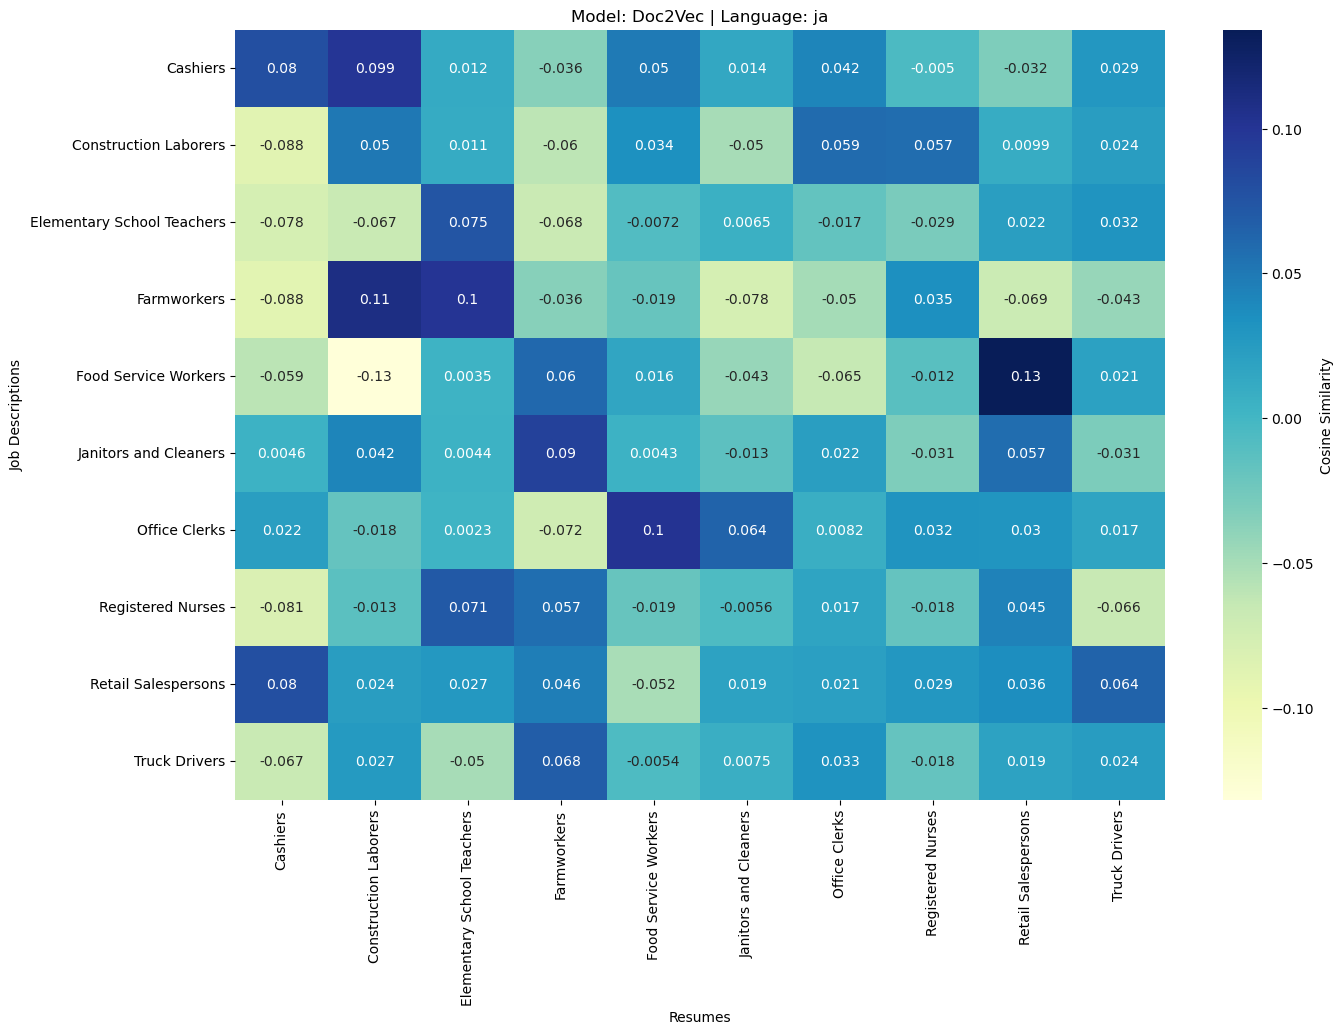

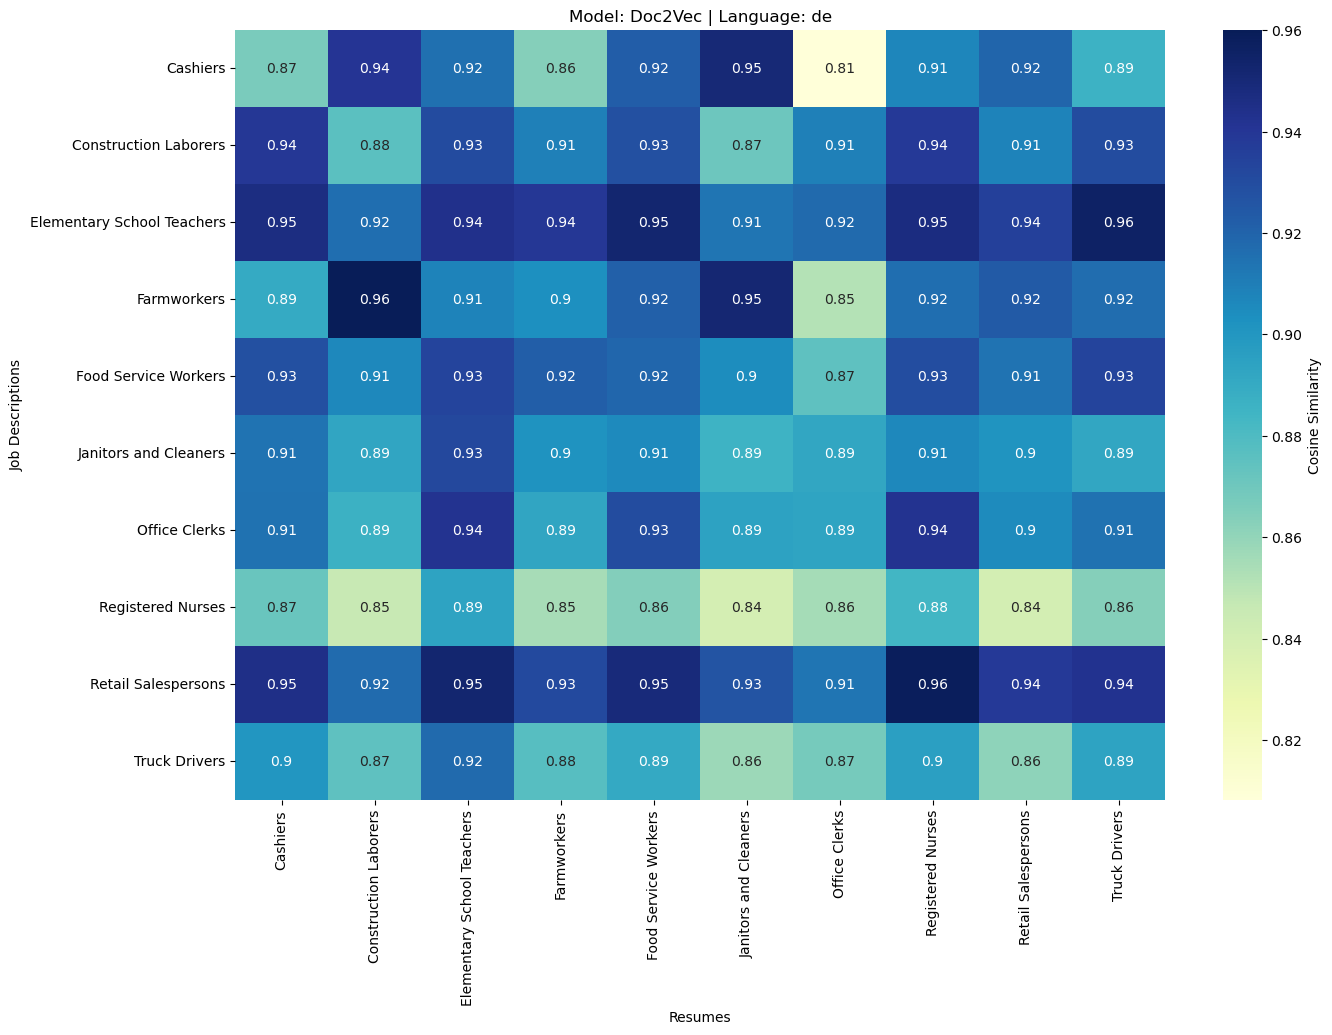

In [ ]:
# Import necessary libraries
import pandas as pd
import boto3
import json
import ipywidgets as widgets
from IPython.display import display
from transformers import BertTokenizer, BertModel
import tensorflow as tf
import tensorflow_hub as hub
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import os  # Import the os library for checking file existence
import matplotlib.pyplot as plt
import seaborn as sns

print(boto3.__version__)

# BERT Initialization
model_name = "bert-base-multilingual-uncased"
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Define a function to translate text
def translate_text(text, source_language, target_language):
    if source_language == target_language:
        return text
    translated_text = client.translate_text(Text=text, SourceLanguageCode=source_language, TargetLanguageCode=target_language)['TranslatedText']
    return translated_text

# Doc2Vec Embeddings (Load a pre-trained model if available)
def get_doc2vec_embedding(text):
    if os.path.isfile("d2v.model"):
        model = Doc2Vec.load("d2v.model")
    else:
        documents = [TaggedDocument(words=text.split(), tags=[str(idx)]) for idx in range(len(text.split()))]
        model = Doc2Vec(documents, vector_size=300, window=5, min_count=1, workers=4)

    return model.infer_vector(text.split())

# Initialize the AWS Bedrock client
bedrock = boto3.client(service_name='bedrock-runtime')
    
# Function to return embedding from Amazon Bedrock Titan model    
def get_titan_embedding(text):
    body = json.dumps({"inputText": text})
    model_d = 'amazon.titan-embed-text-v1'
    mime_type = 'application/json'
    response = bedrock.invoke_model(body=body, modelId=model_d, accept=mime_type, contentType=mime_type)
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')
    return embedding

# Initialize the AWS Translate client
client = boto3.client('translate')

# Supported languages for translation
supported_languages = ["en", "zh", "es", "hi", "ar", "pt", "bn", "ru", "ja", "de"]
translated_csv_file = "translated_job_descriptions_and_resumes.csv"

if not os.path.isfile(translated_csv_file):
    df = pd.read_csv("job-descriptions-and-resumes.csv")
    translated_data = []
    for _, row in df.iterrows():
        profession = row['Profession']
        job_desc = row['Job Description']
        resume = row['Resume']
        for lang in supported_languages:
            if lang != 'en':
                translated_job_desc = translate_text(job_desc, 'en', lang)
                translated_resume = translate_text(resume, 'en', lang)
            else:
                translated_job_desc = job_desc
                translated_resume = resume
            translated_data.append({'Profession': profession, 'Language': lang, 'Translated Job Description': translated_job_desc, 'Translated Resume': translated_resume})
    translated_df = pd.DataFrame(translated_data)
    translated_df.to_csv(translated_csv_file, index=False)
else:
    translated_df = pd.read_csv(translated_csv_file)

# Load the USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Updated list of embedding models to include USE
# embedding_models = ['BERT', 'Doc2Vec', 'Titan', 'USE']
embedding_models = ['Titan', 'BERT', 'Doc2Vec']

# Updated function to get embeddings based on model selection
def generate_embedding(text, model_name):
    if model_name == 'BERT':
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        outputs = model(**inputs)
        return outputs['pooler_output'].detach().numpy()[0]
    elif model_name == 'Doc2Vec':
        return get_doc2vec_embedding(text)
    elif model_name == 'Titan':
        return get_titan_embedding(text)
    elif model_name == 'USE':
        return use_model([text]).numpy()[0]

def generate_heatmap_for_model_and_language(model, lang, results_df):
    subset_results_df = results_df[(results_df['Model'] == model) & (results_df['Language'] == lang)]
    heatmap_data = subset_results_df.pivot_table(values='Similarity', index='Profession', columns='Resume Profession')
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, cbar_kws={'label': 'Cosine Similarity'})
    plt.title(f"Model: {model} | Language: {lang}")
    plt.ylabel('Job Descriptions')
    plt.xlabel('Resumes')
    plt.show()

# Generating the results
results = []

for model_name in embedding_models:
    for _, job_row in translated_df.iterrows():
        for _, resume_row in translated_df.iterrows():
            if job_row['Language'] == resume_row['Language']:  
                lang = job_row['Language']
                job_profession = job_row['Profession']
                resume_profession = resume_row['Profession']
                
                translated_job_desc = job_row['Translated Job Description']
                translated_resume = resume_row['Translated Resume']
                
                job_embedding = generate_embedding(translated_job_desc, model_name)
                resume_embedding = generate_embedding(translated_resume, model_name)
                
                similarity = cosine_similarity([job_embedding], [resume_embedding])[0][0]
                results.append({
                    'Model': model_name, 
                    'Profession': job_profession, 
                    'Resume Profession': resume_profession, 
                    'Language': lang, 
                    'Similarity': similarity
                })
                print(f"Processed {model_name} for job {job_profession} vs resume {resume_profession} in {lang} with similarity score: {similarity}")

results_df = pd.DataFrame(results)

# Generate a heatmap for each language:
for model in embedding_models:
    for lang in supported_languages:
        generate_heatmap_for_model_and_language(model, lang, results_df)